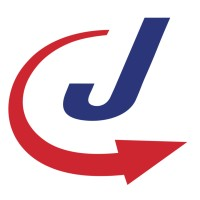

# JiffyShirts.com Data Science Exercise

#### 5 Questions Covering Data Wrangling & Data Manipulation using SQL and Product Recommendation

    by Christian Hardy

## Contents
    1. Data Processing
    2. 5 SQL Questions
    3. Exploratory Data Analysis & In-depth Correlation Analysis
    4. Product Recommendation using Item-based Collaborative Filtering

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option('display.max_columns', 500)

import numpy as np

import sqlite3

import phik

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

import xgboost as xgb
from xgboost import plot_importance

import seaborn as sns
import matplotlib.pyplot as plt

# 1. Data Processing

In [2]:
# Create a SQLite database
conn = sqlite3.connect('jiffy-tshirt-database.db')

In [3]:
# Create df and SQL tables
#customers_df = pd.read_csv('data/customers.csv')
#line_items_df = pd.read_csv('data/line_items.csv')
#orders_df = pd.read_csv('data/orders.csv')

#customers_df.to_sql('customers', conn, if_exists='replace', index=False)
#line_items_df.to_sql('line_items', conn, if_exists='replace', index=False)
#orders_df.to_sql('orders', conn, if_exists='replace', index=False)

In [4]:
# Run query and read the output into a df
customer_query1 = "SELECT * FROM customers"
customers_table = pd.read_sql_query(customer_query1, conn)
customers_table.head()

,customer_uid,is_business,has_account,bill_state,acquisition_channel
0,7d30104b82c22393003ac3c07b491c15,0,0,OK,coupon aggregator
1,77a48e4c4a69458d3421c54058350f93,0,0,CA,organic search
2,c9fe0dadc9e25ab478144bbd3a0ae750,0,0,WA,organic search
3,7a8bdb597d753c6c7430ea4e1d52fc48,0,0,TX,organic search
4,becb1413c375caba8707085efaac08e9,0,0,IL,organic search


In [5]:
line_items_query1 = "SELECT * FROM line_items"
line_items_table = pd.read_sql_query(line_items_query1, conn)
line_items_table.head()

,line_item_id,order_id,quantity,selling_price,supplier_cost,product_category,color,size
0,1073625002,31323782,1,9.25,4.37,OTHER,BLACK,2XL
1,8055020046,22921936,1,9.25,4.37,OTHER,BLACK,2XL
2,5008546658,4435273,1,9.25,4.37,OTHER,BLACK,2XL
3,1013699827,6843815,1,9.25,4.37,OTHER,BLACK,2XL
4,1022146551,9923010,1,9.25,4.37,OTHER,RED,2XL


In [6]:
orders_query1 = "SELECT * FROM orders"
orders_table = pd.read_sql_query(orders_query1, conn)
orders_table.head()

,order_id,customer_uid,order_timestamp,discount,ship_state,shipping_revenue,shipping_cost,returned
0,38831,a6730d49e0989b2cc0158c6182fafb93,2015-11-30 05:03:15.159,0.00,FL,0.00,6.8,0
1,45499,ae2e8c1fa5326e1f793d4c02f720156c,2015-11-30 19:52:10.830,0.00,TN,5.95,6.8,1
2,69415,ba200839cd304b8342f8c5d0eb4d7c75,2015-12-02 22:54:40.380,0.00,TN,0.00,6.8,0
3,68761,b34cf44effba2eeb4d2a4db55ffe49d7,2015-12-02 20:24:30.925,0.00,MI,0.00,6.8,0
4,120057,10cedfe0d36280b646ff877ac1d916cb,2015-12-07 22:59:26.486,0.04,OH,0.00,6.8,0


---

---

# 2. 5 SQL Questions

In [7]:
# Q1: How many orders were completed in 2018?
orders_2018_query = """
                    SELECT COUNT(DISTINCT order_id) FROM orders
                    WHERE strftime('%Y', datetime(order_timestamp, 'localtime')) = '2018';
                    """
orders_2018_count = pd.read_sql_query(orders_2018_query, conn).iloc[0, 0]

print(f"Number of orders completed in 2018: {orders_2018_count}")

Number of orders completed in 2018: 9228


In [8]:
# Q2: How many orders were completed in 2018 containing at least 10 units?
orders_2018_10_units_query = """
                             SELECT COUNT(DISTINCT o.order_id) 
                             FROM orders o
                             JOIN line_items li ON o.order_id = li.order_id
                             WHERE strftime('%Y', datetime(o.order_timestamp, 'localtime')) = '2018'
                             GROUP BY o.order_id
                             HAVING SUM(li.quantity) >= 10;
                             """
orders_2018_10_units_count = pd.read_sql_query(orders_2018_10_units_query, conn).shape[0]

print(f"Number of orders completed in 2018 containing at least 10 units: {orders_2018_10_units_count}")

Number of orders completed in 2018 containing at least 10 units: 5151


In [9]:
# Q3: How many customers have ever purchased a medium sized sweater with a discount?
medium_sweater_discount_query = """
                                SELECT COUNT(DISTINCT c.customer_uid)
                                FROM customers c
                                JOIN orders o ON c.customer_uid = o.customer_uid
                                JOIN line_items li ON o.order_id = li.order_id
                                WHERE li.product_category = 'Sweater'
                                AND li.size = 'M'
                                AND o.discount > 0;
                                """
medium_sweater_discount_count = pd.read_sql_query(medium_sweater_discount_query, conn).iloc[0, 0]

print(f"Number of customers who have ever purchased a medium-sized sweater with a discount: {medium_sweater_discount_count}")

Number of customers who have ever purchased a medium-sized sweater with a discount: 753


In [10]:
# Q4: How profitable was our most profitable month?
most_profitable_month_query = """
                              SELECT strftime('%Y-%m', datetime(o.order_timestamp, 'localtime')) AS month,
                              SUM((li.selling_price - li.supplier_cost) * li.quantity + o.shipping_revenue - o.shipping_cost) AS total_profit
                              FROM orders o
                              JOIN line_items li ON o.order_id = li.order_id
                              GROUP BY month
                              ORDER BY total_profit DESC
                              LIMIT 1;
                              """
most_profitable_month_data = pd.read_sql_query(most_profitable_month_query, conn)

most_profitable_month = most_profitable_month_data.iloc[0, 0]
total_profit = most_profitable_month_data.iloc[0, 1]
print(f"The most profitable month was {most_profitable_month} with a total profit of ${total_profit:.2f}")

The most profitable month was 2016-03 with a total profit of $4468.77


In [11]:
# Q5: What is the return rate for business vs. non-business customers?
return_rate_query = """
                    SELECT c.is_business,
                    COUNT(DISTINCT CASE WHEN o.returned = 1 THEN o.order_id ELSE NULL END) AS returned_orders,
                    COUNT(DISTINCT o.order_id) AS total_orders,
                   (COUNT(DISTINCT CASE WHEN o.returned = 1 THEN o.order_id ELSE NULL END) * 1.0 / COUNT(DISTINCT o.order_id)) * 100 AS return_rate
                    FROM customers c
                    JOIN orders o ON c.customer_uid = o.customer_uid
                    GROUP BY c.is_business;
                    """
return_rate_data = pd.read_sql_query(return_rate_query, conn)

return_rate_data['return_rate'] = return_rate_data['return_rate'].round(2)
print("Return Rate for Business vs. Non-Business Customers:")
return_rate_data.head()

Return Rate for Business vs. Non-Business Customers:


,is_business,returned_orders,total_orders,return_rate
0,0,900,18278,4.92
1,1,1899,28155,6.74


---

---

# 3. Exploratory Data Analysis & In-depth Correlation Analysis

### Analysis of Customer, Order & Line Item Tables

    Exploratory data analysis is performed before any advanced analysis takes place. I want to get a good 
    understanding of what is contained in the tables and understand the nature of the data I'm working 
    with. 
    
    Uni/Bi-variate exploratory data analysis:
    
     ● Descriptive statistics
     ● Data types and missing values
     ● Distribution of selling price
     ● Distribution of quantity
     ● Distribution of shipping revenue
     ● Distribution of supplier cost
     ● Distribution of business customers     
     ● Distribution of acquisition channels
     
     ● New vs returning customers
     ● High vs Low value customers 
     ● Highest selling products
     ● Total sales by state
     ● Distribution of Gross Profit Per Item
           - Log scale
           - Zoomed negative range
           - Finer bins
           - Item by category
     
     ● Total Revenue by Customer Type 
     ● Sales over time
     ● Total sales and total number of items sold: 
           - Per day
           - Per month
           - Between 2019 & 2020
           - 2020
     
 
    Observations:
          
     ● With high frequency, the the average selling price of the product for the customer is between $1 
       and $6.
       
     ● With high frequency, the number of units on each line item for customers is between 1 line item 
       and 2 line items.
       
     ● Although more customers are not a business, most company revenue comes from customers that are 
       businesses.
     
     ● Slightly more new vs returning customers are coming in. Is customer retention an issue?
     
     ● Paid search and direct marketing are the most frequent acquisition channels.     
     
     ● Seasonality seems apparent when looking at the total sales/number of items sold per time period.
     
     
    Insights:
    
     ● For the distribution of gross profit per item plot, the vertical dashed line is at 0 with some 
       of the histogram bars to the right between 25 and 30 units of currency, and a very small 
       frequency to the left. 
       
        - This is very good news for the business as it suggests that a profit is being made on a 
          majority of the items included in the analysis. 
             
        - There are a small number of items being sold at a loss, specifically fashion tees and 'Other' 
          (what does this mean?). As fashion tees make up the majority of items, it would be interesting 
          to further segment this to see why this section of fashion tees ends up to the left of the 
          vertical line.           

In [12]:
# Get columns for descriptive statistics
pandas_describe_query = """
                        SELECT c.customer_uid, c.is_business, c.has_account, c.bill_state, c.acquisition_channel,
                        o.order_id, o.order_timestamp, o.discount, o.ship_state, o.shipping_revenue, 
                        o.shipping_cost, o.returned,
                        li.line_item_id, li.product_category, li.quantity, li.supplier_cost, li.selling_price,
                        li.color,li.size
                        FROM customers c
                        JOIN orders o ON c.customer_uid = o.customer_uid
                        JOIN line_items li ON o.order_id = li.order_id;
                        """
# Put data into df
pandas_describe = pd.read_sql_query(pandas_describe_query, conn)
pandas_describe_business = pandas_describe
pandas_describe_business = pandas_describe_business[pandas_describe_business['is_business'] == 0] # 0 = non business, 1 = business
pandas_describe_business.describe()

,is_business,has_account,order_id,discount,shipping_revenue,shipping_cost,returned,line_item_id,quantity,supplier_cost,selling_price
count,133112.0,133112.000000,1.331120e+05,133112.000000,133112.000000,133112.000000,133112.000000,1.331120e+05,133112.000000,133105.000000,133104.000000
mean,0.0,0.710905,2.795887e+07,0.038720,1.812952,8.340510,0.063030,1.234073e+10,2.169128,3.629140,6.565614
std,0.0,0.453344,2.344051e+07,0.052662,3.383247,1.834326,0.243017,1.782598e+10,3.669186,2.513964,5.585152
min,0.0,0.000000,1.533000e+03,0.000000,0.000000,0.000000,0.000000,1.000026e+09,1.000000,0.000000,1.020000
25%,0.0,0.000000,1.064072e+07,0.000000,0.000000,7.390000,0.000000,3.053915e+09,1.000000,1.930000,3.260000
50%,0.0,1.000000,2.174434e+07,0.000000,0.000000,8.000000,0.000000,8.008570e+09,1.000000,2.940000,5.090000
75%,0.0,1.000000,3.522904e+07,0.075000,0.000000,9.020000,0.000000,1.708070e+10,2.000000,4.380000,8.100000
max,0.0,1.000000,9.639161e+07,0.198000,10.000000,19.950000,1.000000,1.181034e+11,320.000000,71.630000,169.000000


In [13]:
# Data types and missing values
line_item_data_types_missing_values_query = """
                                            PRAGMA table_info(line_items);
                                            """
line_item_data_types_missing_values_df = pd.read_sql_query(line_item_data_types_missing_values_query, conn)
line_item_data_types_missing_values_df.head()

,cid,name,type,notnull,dflt_value,pk
0,0,line_item_id,INTEGER,0,None,0
1,1,order_id,INTEGER,0,None,0
2,2,quantity,INTEGER,0,None,0
3,3,selling_price,REAL,0,None,0
4,4,supplier_cost,REAL,0,None,0


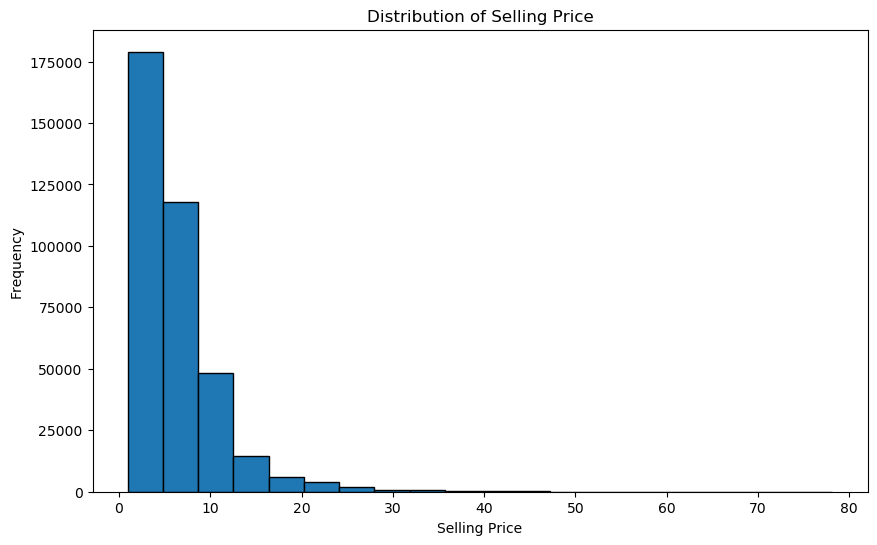

In [14]:
# Univariate EDA
# Distribution of selling price
query_selling_price = "SELECT selling_price FROM line_items"
df_selling_price = pd.read_sql_query(query_selling_price, conn)
df_selling_price = df_selling_price[df_selling_price['selling_price'] < 80]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(df_selling_price['selling_price'], bins=20, edgecolor='black')
plt.title('Distribution of Selling Price')
plt.xlabel('Selling Price')
plt.ylabel('Frequency')
plt.show()

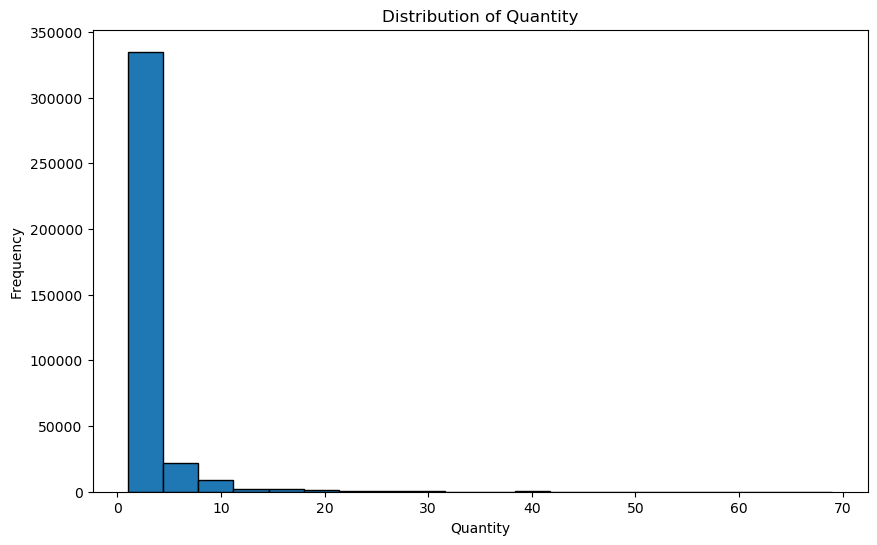

In [15]:
# Univariate EDA
# Distribution of quantity
query_quantity = "SELECT quantity FROM line_items"
df_quantity = pd.read_sql_query(query_quantity, conn)
df_quantity = df_quantity[df_quantity['quantity'] < 70]

plt.figure(figsize=(10, 6))
plt.hist(df_quantity['quantity'], bins=20, edgecolor='black')
plt.title('Distribution of Quantity')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.show()

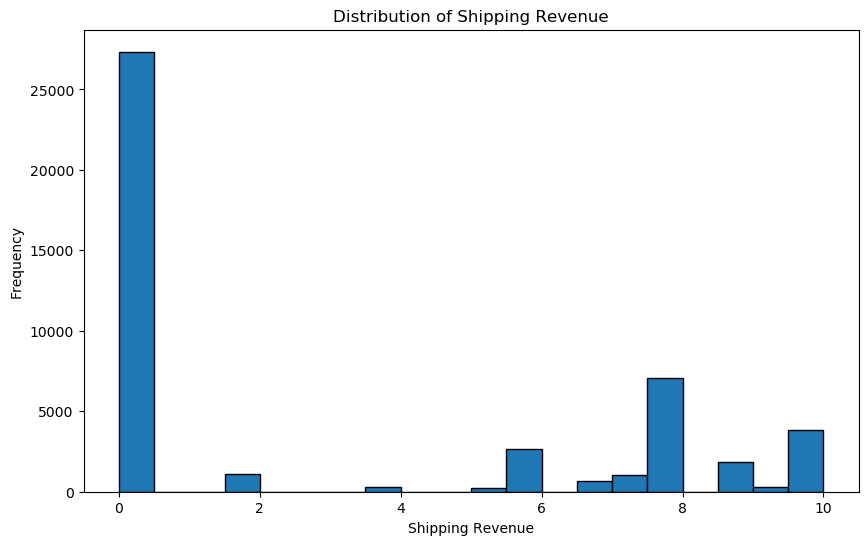

In [16]:
# Univariate EDA
# Distribution of shipping revenue
query_shipping_revenue = "SELECT shipping_revenue FROM orders"
df_shipping_revenue = pd.read_sql_query(query_shipping_revenue, conn)

plt.figure(figsize=(10, 6))
plt.hist(df_shipping_revenue['shipping_revenue'], bins=20, edgecolor='black')
plt.title('Distribution of Shipping Revenue')
plt.xlabel('Shipping Revenue')
plt.ylabel('Frequency')
plt.show()

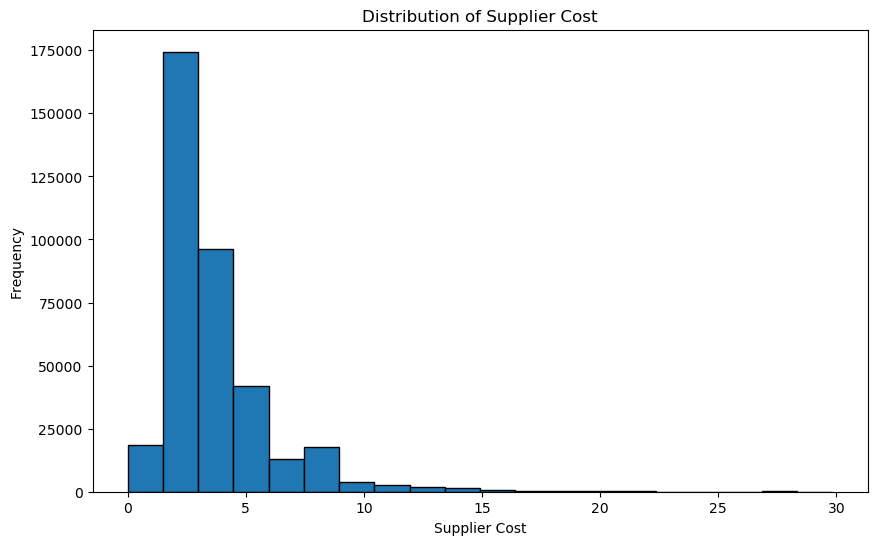

In [17]:
# Univariate EDA
# Distribution of supplier cost
query_shipping_revenue = "SELECT supplier_cost FROM line_items"
df_shipping_revenue = pd.read_sql_query(query_shipping_revenue, conn)
df_shipping_revenue = df_shipping_revenue[df_shipping_revenue['supplier_cost'] < 30]

plt.figure(figsize=(10, 6))
plt.hist(df_shipping_revenue['supplier_cost'], bins=20, edgecolor='black')
plt.title('Distribution of Supplier Cost')
plt.xlabel('Supplier Cost')
plt.ylabel('Frequency')
plt.show()

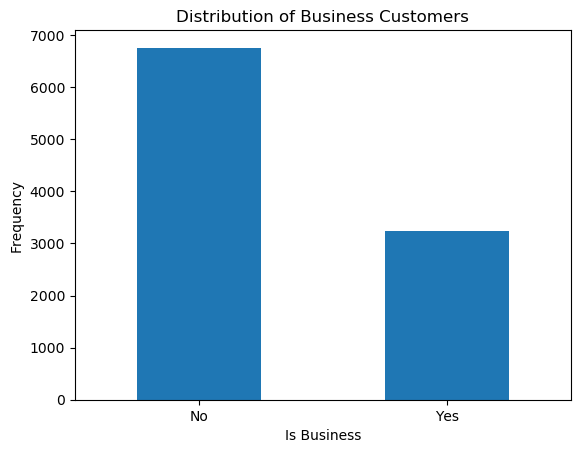

In [18]:
# Univariate EDA
# Distribution of business customers
query_is_business = "SELECT is_business FROM customers"
df_is_business = pd.read_sql_query(query_is_business, conn)

# Plot bar chart
df_is_business['is_business'].value_counts().plot(kind='bar')
plt.title('Distribution of Business Customers')
plt.xlabel('Is Business')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'], rotation=0)
plt.show()

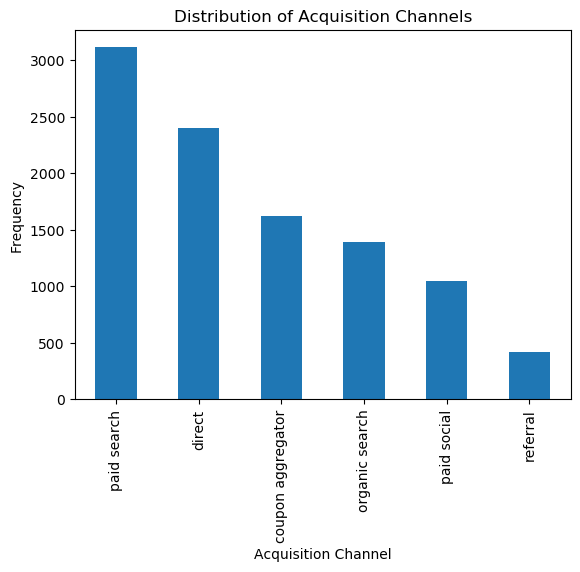

In [19]:
# Univariate EDA
# Distribution of acquisition channels
query_acquisition_channel = "SELECT acquisition_channel FROM customers"
df_acquisition_channel = pd.read_sql_query(query_acquisition_channel, conn)

df_acquisition_channel['acquisition_channel'].value_counts().plot(kind='bar')
plt.title('Distribution of Acquisition Channels')
plt.xlabel('Acquisition Channel')
plt.ylabel('Frequency')
plt.show()

In [20]:
# Univariate EDA
# Customer segmentation aggregation
# looks at aggregated metrics for different segments of customers 
#       - new vs returning etc.
query_new_returning = """
                      SELECT customer_uid, COUNT(DISTINCT order_id) as num_orders
                      FROM orders
                      GROUP BY customer_uid;
                      """
df_new_returning = pd.read_sql_query(query_new_returning, conn)
df_new_returning['customer_type'] = 'Returning'
df_new_returning.loc[df_new_returning['num_orders'] == 1, 'customer_type'] = 'New'

print(df_new_returning['customer_type'].value_counts())

New          4497
Returning    3960
Name: customer_type, dtype: int64


In [21]:
# Univariate EDA
# Customer segmentation aggregation
# looks at aggregated metrics for different segments of customers 
#       - high-value vs low-value, etc.
query_lifetime_value = """
                       SELECT o.customer_uid, SUM(li.selling_price * li.quantity) as lifetime_value
                       FROM orders o
                       JOIN line_items li ON o.order_id = li.order_id
                       GROUP BY o.customer_uid;
                       """
df_lifetime_value = pd.read_sql_query(query_lifetime_value, conn)
median_value = df_lifetime_value['lifetime_value'].median()
df_lifetime_value['customer_value'] = 'Low-Value'
df_lifetime_value.loc[df_lifetime_value['lifetime_value'] > median_value, 'customer_value'] = 'High-Value'

print(df_lifetime_value['customer_value'].value_counts())

Low-Value     4229
High-Value    4228
Name: customer_value, dtype: int64


In [22]:
# Univariate EDA
# Highest selling products
query_highest_selling_products = """
                                 SELECT product_category, SUM(quantity) as total_quantity
                                 FROM line_items
                                 GROUP BY product_category
                                 ORDER BY total_quantity DESC;
                                 """
df_highest_selling_products = pd.read_sql_query(query_highest_selling_products, conn)
print("Highest selling products:")
df_highest_selling_products.head()

Highest selling products:


,product_category,total_quantity
0,Basic Tee,328378
1,Fashion Tee,254330
2,OTHER,243882
3,Sweater,41699
4,Tank Top,5771


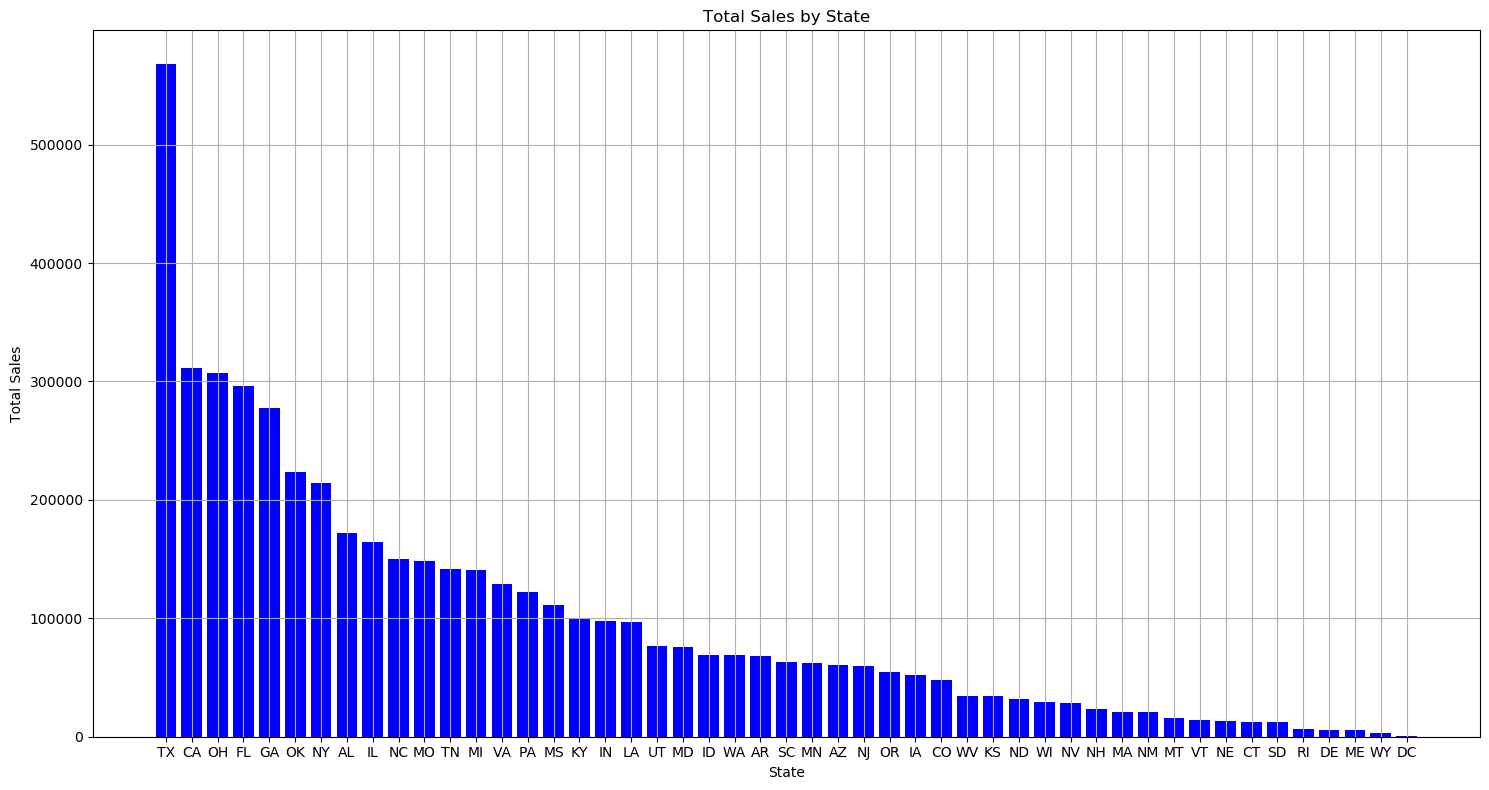

In [23]:
# Univariate EDA
# Total sales by state
query_sales_by_state = """
                       SELECT o.ship_state, 
                              SUM(li.selling_price * li.quantity) as total_sales
                       FROM orders o
                       JOIN line_items li ON o.order_id = li.order_id
                       GROUP BY o.ship_state
                       ORDER BY total_sales DESC;
                       """
df_sales_by_state = pd.read_sql_query(query_sales_by_state, conn)

fig, ax = plt.subplots(figsize=(15, 8))

ax.bar(df_sales_by_state['ship_state'], df_sales_by_state['total_sales'], color='blue')
ax.set_title('Total Sales by State')
ax.set_xlabel('State')
ax.set_ylabel('Total Sales')
ax.grid(True)

plt.tight_layout()
plt.show()

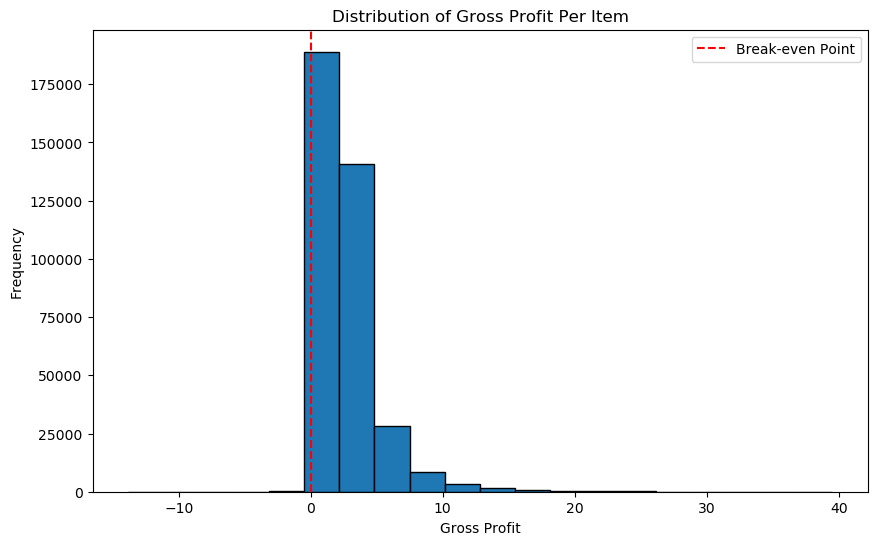

In [24]:
# Univariate EDA
# Get the gross profit per item
query_gross_profit = """
                     SELECT (li.selling_price - li.supplier_cost) as gross_profit
                     FROM line_items li
                     """
df_gross_profit = pd.read_sql_query(query_gross_profit, conn)

# Filter extreme values
df_gross_profit = df_gross_profit[df_gross_profit['gross_profit'] < 40]

plt.figure(figsize=(10, 6))
plt.hist(df_gross_profit['gross_profit'], bins=20, edgecolor='black')
plt.title('Distribution of Gross Profit Per Item')
plt.xlabel('Gross Profit')
plt.ylabel('Frequency')

# Add a vertical line at x=0 to indicate the break-even point
plt.axvline(x=0, color='red', linestyle='--', label='Break-even Point')

plt.legend()
plt.show()

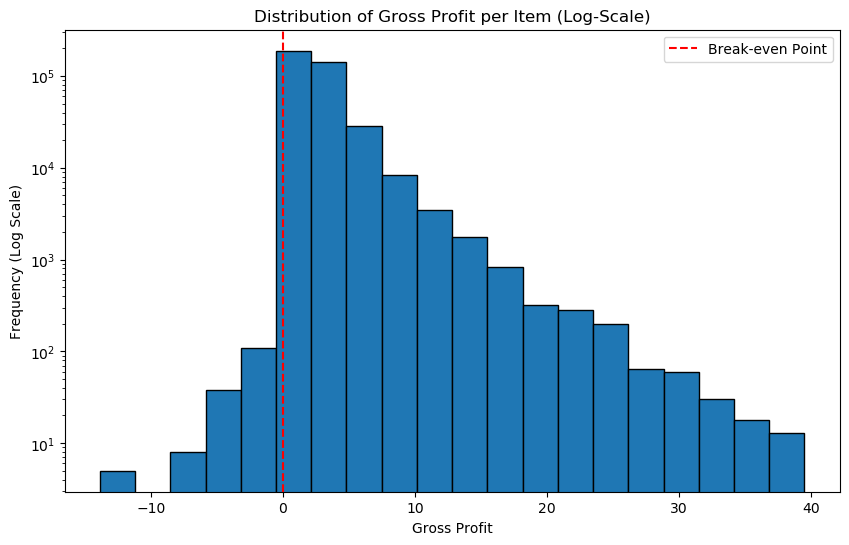

In [25]:
# Log-scale the y axis
plt.figure(figsize=(10, 6))
plt.hist(df_gross_profit['gross_profit'], bins=20, edgecolor='black', log=True)
plt.axvline(x=0, color='red', linestyle='--', label='Break-even Point')
plt.title('Distribution of Gross Profit per Item (Log-Scale)')
plt.xlabel('Gross Profit')
plt.ylabel('Frequency (Log Scale)')
plt.legend()
plt.show()

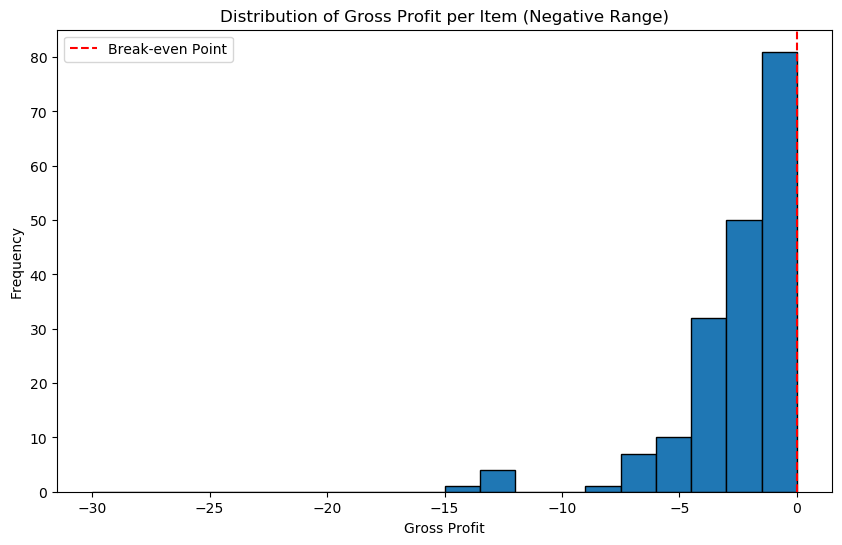

In [26]:
# Zoom in on the negative range
plt.figure(figsize=(10, 6))
plt.hist(df_gross_profit['gross_profit'], bins=20, edgecolor='black', range=[-30, 0])
plt.axvline(x=0, color='red', linestyle='--', label='Break-even Point')
plt.title('Distribution of Gross Profit per Item (Negative Range)')
plt.xlabel('Gross Profit')
plt.ylabel('Frequency')
plt.legend()
plt.show()

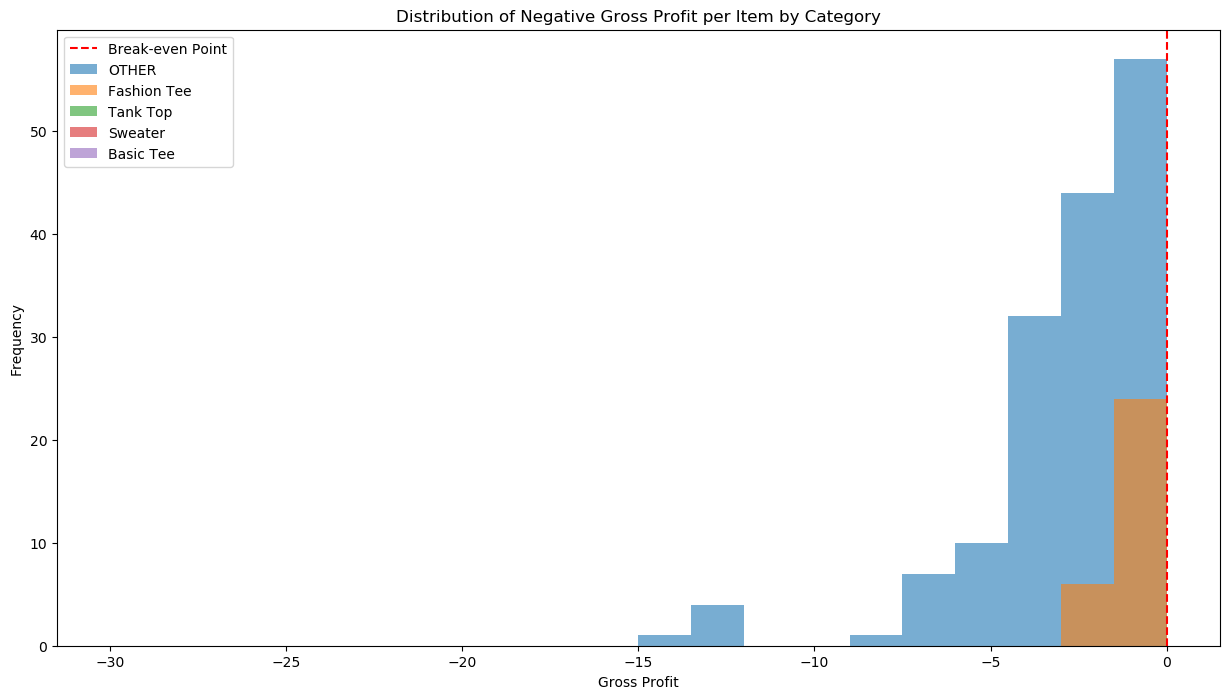

In [27]:
# Get the gross profit per item, along with the product category
query_gross_profit_category = """
                              SELECT li.product_category, (li.selling_price - li.supplier_cost) as gross_profit
                              FROM line_items li
                              """
df_gross_profit_category = pd.read_sql_query(query_gross_profit_category, conn)

plt.figure(figsize=(15, 8))

# List unique categories
categories = df_gross_profit_category['product_category'].unique()

# Zoom in on the negative range of gross profits
for category in categories:
    subset = df_gross_profit_category[df_gross_profit_category['product_category'] == category]
    plt.hist(subset['gross_profit'], bins=20, range=[-30, 0], alpha=0.6, label=str(category))

plt.axvline(x=0, color='red', linestyle='--', label='Break-even Point')

plt.title('Distribution of Negative Gross Profit per Item by Category')
plt.xlabel('Gross Profit')
plt.ylabel('Frequency')
plt.legend()
plt.show()

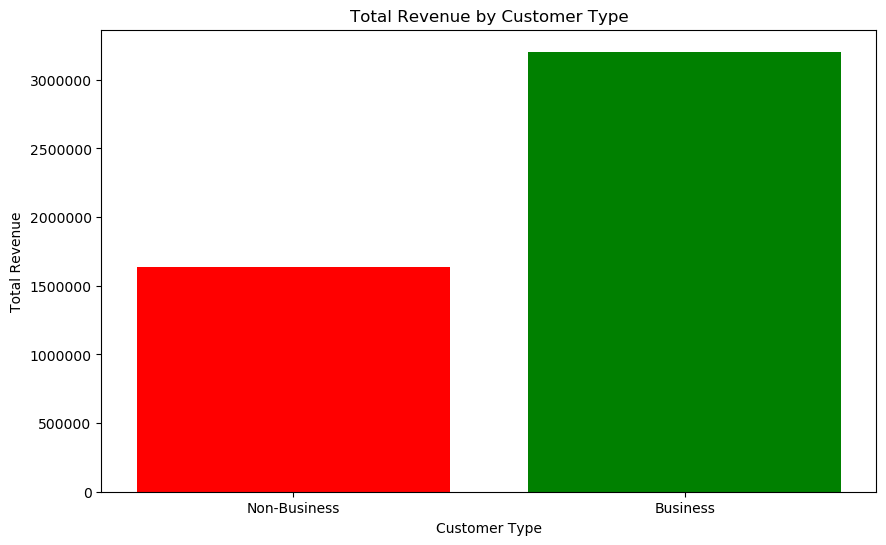

In [28]:
# Get the revenue per order, along with customer type (business or non-business)
query_revenue_by_type = """
                        SELECT c.is_business, SUM(li.selling_price * li.quantity) as total_revenue
                        FROM customers c
                        JOIN orders o ON c.customer_uid = o.customer_uid
                        JOIN line_items li ON o.order_id = li.order_id
                        GROUP BY c.is_business
                        """
df_revenue_by_type = pd.read_sql_query(query_revenue_by_type, conn)

plt.figure(figsize=(10, 6))

plt.bar(df_revenue_by_type['is_business'], df_revenue_by_type['total_revenue'], color=['red', 'green'])

plt.title('Total Revenue by Customer Type')
plt.xlabel('Customer Type')
plt.xticks(ticks=[0, 1], labels=['Non-Business', 'Business'])
plt.ylabel('Total Revenue')

plt.show()

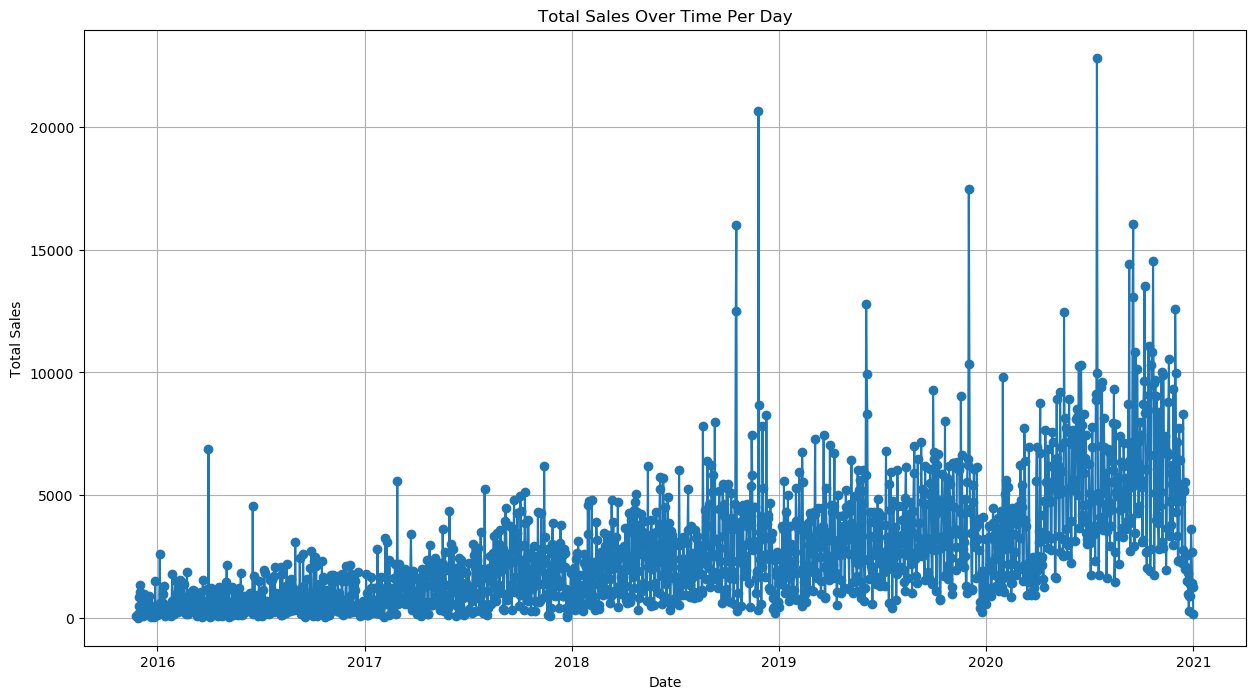

In [29]:
# Bivariate EDA
# Sales over time
query_sales_by_time = """
                      SELECT DATE(order_timestamp) as date,
                             strftime('%m', order_timestamp) as month,
                             strftime('%Y', order_timestamp) as year,
                             SUM(li.selling_price * li.quantity) as total_sales
                      FROM orders o
                      JOIN line_items li ON o.order_id = li.order_id
                      GROUP BY date, month, year;
                      """
df_sales_by_time = pd.read_sql_query(query_sales_by_time, conn)

df_sales_by_time['date'] = pd.to_datetime(df_sales_by_time['date'])

df_sales_by_time = df_sales_by_time.sort_values('date')

plt.figure(figsize=(15, 8))
plt.plot(df_sales_by_time['date'], df_sales_by_time['total_sales'], marker='o')
plt.title('Total Sales Over Time Per Day')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

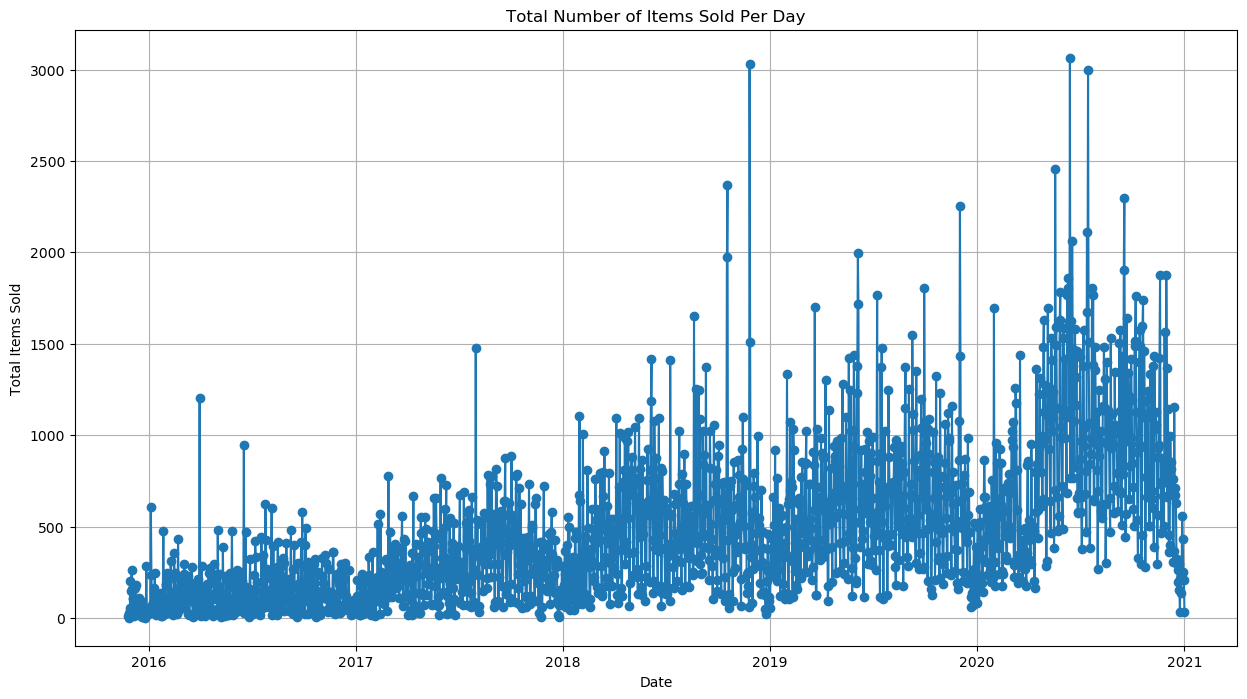

In [30]:
# Bivariate EDA
# Number of items sold per day, per month
query_items_sold_per_day = """
                           SELECT DATE(order_timestamp) as date, SUM(quantity) as total_items_sold
                           FROM orders o
                           JOIN line_items li ON o.order_id = li.order_id
                           GROUP BY DATE(order_timestamp);
                           """
df_items_sold_per_day = pd.read_sql_query(query_items_sold_per_day, conn)

df_items_sold_per_day['date'] = pd.to_datetime(df_items_sold_per_day['date'])

df_items_sold_per_day = df_items_sold_per_day.sort_values('date')

plt.figure(figsize=(15, 8))
plt.plot(df_items_sold_per_day['date'], df_items_sold_per_day['total_items_sold'], marker='o')
plt.title('Total Number of Items Sold Per Day')
plt.xlabel('Date')
plt.ylabel('Total Items Sold')
plt.grid(True)
plt.show()

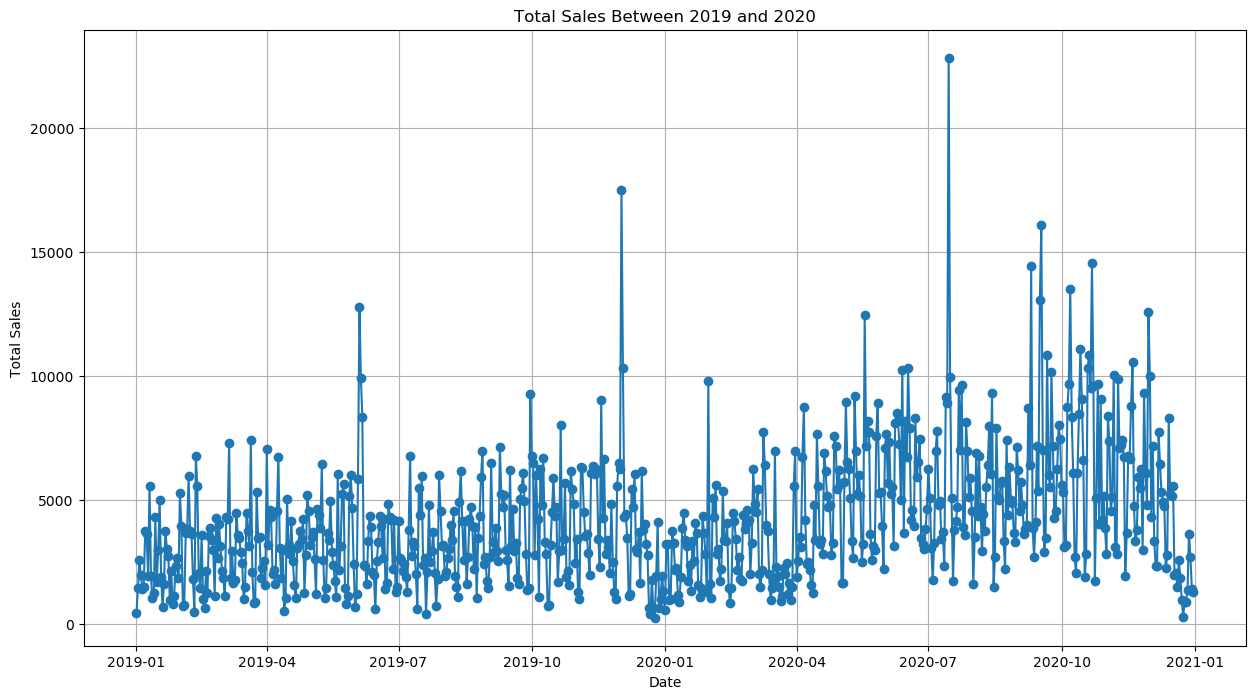

In [31]:
# Bivariate EDA
# Sales between 2019 & 2020
# Convert the date and year columns to appropriate data types
df_sales_by_time['date'] = pd.to_datetime(df_sales_by_time['date'])
df_sales_by_time['year'] = df_sales_by_time['year'].astype(int)

# Filter df for the years 2019 and 2020
df_sales_by_time_filtered = df_sales_by_time[(df_sales_by_time['year'] == 2019) | (df_sales_by_time['year'] == 2020)]

df_sales_by_time_filtered = df_sales_by_time_filtered.sort_values('date')

plt.figure(figsize=(15, 8))
plt.plot(df_sales_by_time_filtered['date'], df_sales_by_time_filtered['total_sales'], marker='o')
plt.title('Total Sales Between 2019 and 2020')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

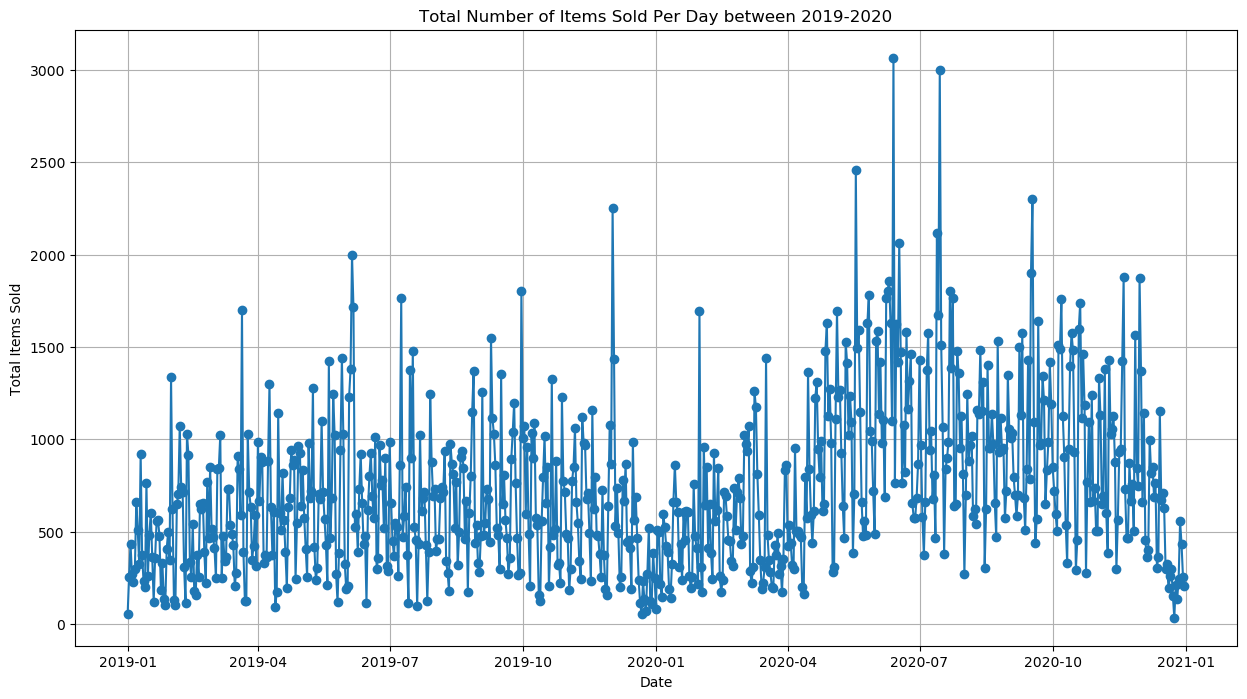

In [32]:
# Bivariate EDA
df_items_sold_per_day['date'] = pd.to_datetime(df_items_sold_per_day['date'])

# Filter df to only include data from 2019 and 2020
df_items_sold_per_day['year'] = df_items_sold_per_day['date'].dt.year  # Extract year from date
df_items_sold_per_day_filtered = df_items_sold_per_day[(df_items_sold_per_day['year'] == 2019) | (df_items_sold_per_day['year'] == 2020)]

df_items_sold_per_day_filtered = df_items_sold_per_day_filtered.sort_values('date')

plt.figure(figsize=(15, 8))
plt.plot(df_items_sold_per_day_filtered['date'], df_items_sold_per_day_filtered['total_items_sold'], marker='o')
plt.title('Total Number of Items Sold Per Day between 2019-2020')
plt.xlabel('Date')
plt.ylabel('Total Items Sold')
plt.grid(True)
plt.show()

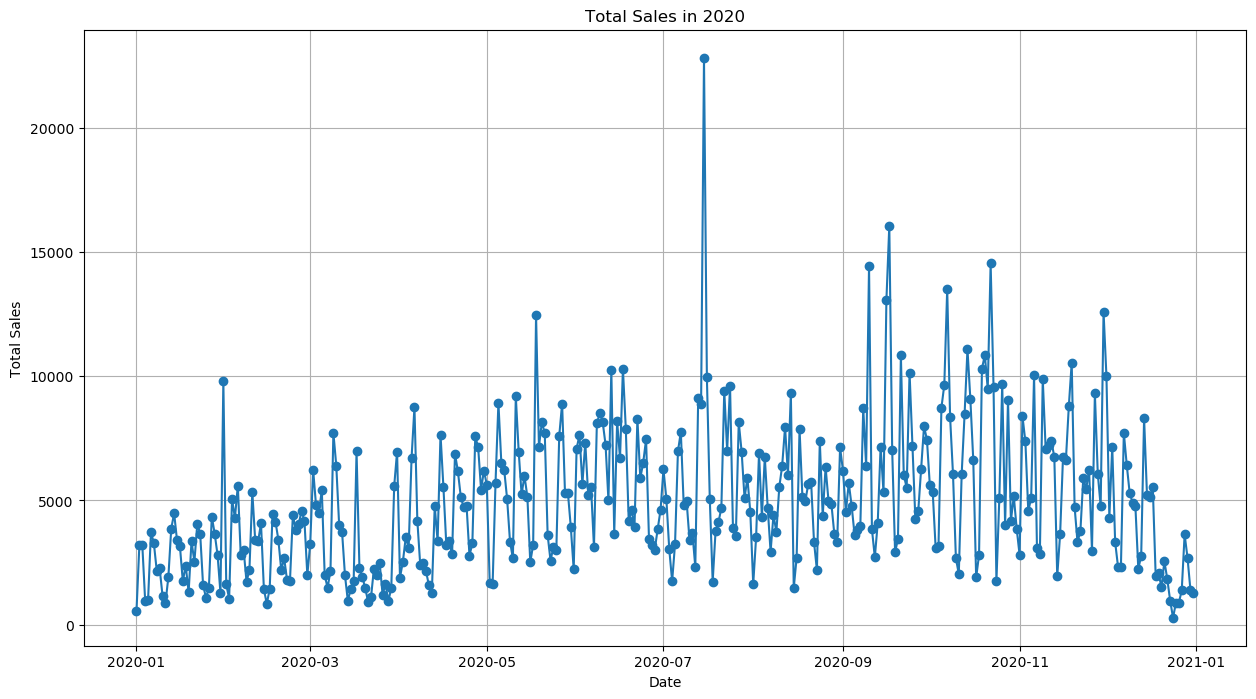

In [33]:
# Bivariate EDA
# Sales in 2020
df_sales_by_time['date'] = pd.to_datetime(df_sales_by_time['date'])
df_sales_by_time['year'] = df_sales_by_time['year'].astype(int)

# Filter df for the years 2019 and 2020
df_sales_by_time_filtered = df_sales_by_time[(df_sales_by_time['year'] == 2020)]

df_sales_by_time_filtered = df_sales_by_time_filtered.sort_values('date')

plt.figure(figsize=(15, 8))
plt.plot(df_sales_by_time_filtered['date'], df_sales_by_time_filtered['total_sales'], marker='o')
plt.title('Total Sales in 2020')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

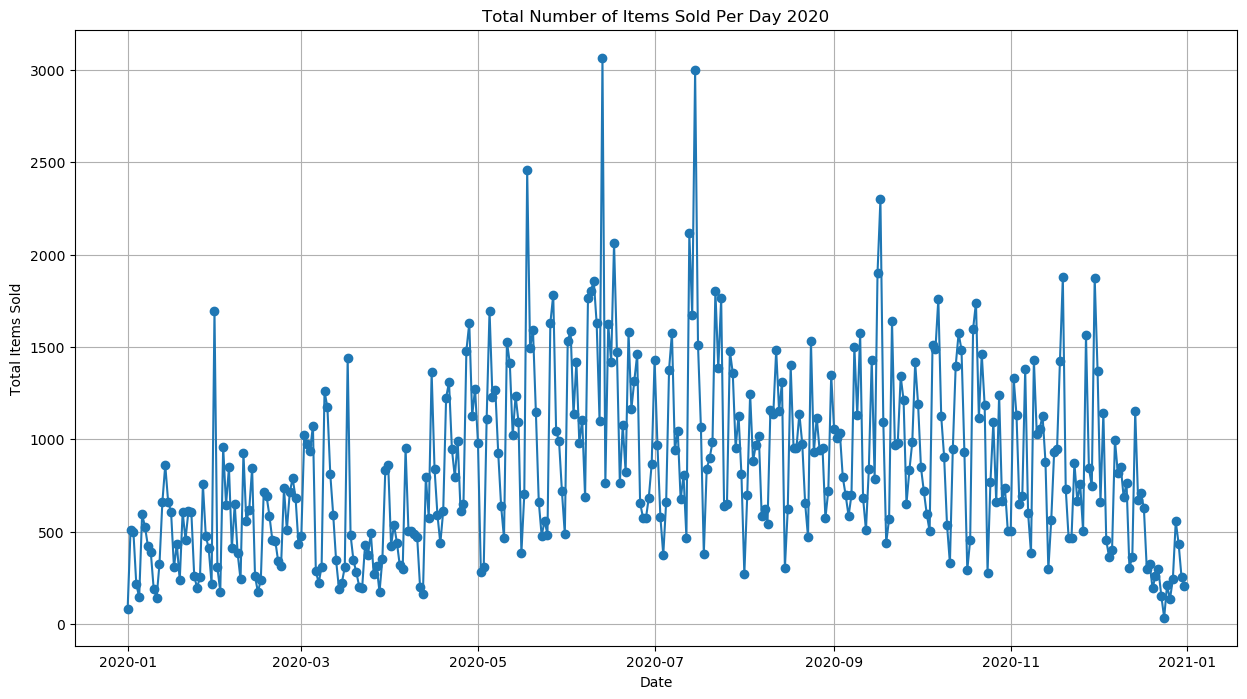

In [34]:
# Bivariate EDA
df_items_sold_per_day['date'] = pd.to_datetime(df_items_sold_per_day['date'])

# Filter df to only include data from 2019 and 2020
df_items_sold_per_day['year'] = df_items_sold_per_day['date'].dt.year
df_items_sold_per_day_filtered = df_items_sold_per_day[(df_items_sold_per_day['year'] == 2020) | (df_items_sold_per_day['year'] == 2020)]

df_items_sold_per_day_filtered = df_items_sold_per_day_filtered.sort_values('date')

plt.figure(figsize=(15, 8))
plt.plot(df_items_sold_per_day_filtered['date'], df_items_sold_per_day_filtered['total_items_sold'], marker='o')
plt.title('Total Number of Items Sold Per Day 2020')
plt.xlabel('Date')
plt.ylabel('Total Items Sold')
plt.grid(True)
plt.show()

# In Depth Correlation Analysis

### Feature Correlation Heatmap
    
    The further away the correlation coefficient is from zero in either direction indicates how highly 
    correlated(positive) or not correlated(negative) the strength of the relationship is between two 
    variables. Values approaching 70% risk multicollinearity and should be further understood.   
    
    In this section I engineered features based on existing columns from the order, customer and 
    line_item tables. The features I came up with are customer, product, time, order, and seasonal-based 
    features. 
    
### Explanation of Engineered Features    

       Lag features (all have 7 day window):
           
           - Total Spend:Total spending by a customer.
           - Average Discount: Average discount used by a customer.
           - Order Count: Number of orders made by a customer.
           - Product Sales: The total number of sales for a product.
           - Product Returns: The total number of returns for a product.
           - Product Revenue: The total revenue generated from a product.
           - Shipping Cost: The shipping cost for the order made.
           - Shipping Revenue: The shipping revenue for the order.
       
       Other features:
       
           - Customer Lifetime Value: Total revenue generated from a customer across all transactions.
           - Purchase Frequency: The number of orders made by a customer.
           - Average Discount Used: The average discount rate used across all transactions by a customer.
           - Purchase Frequency by State: Average or total spending, frequency, segmented by state.
           - Product Profitability: The profitability of each product.
           - Product Return Rate: The ratio of the number of returned items to sold items for each product.
           - Product Popularity: The number of times a product appears in orders.
           - Seasonal Indicators: Flags indicating whether the order was made during a holiday season, 
             weekend, etc.
           
           - Shipping Efficiency: The net gain or loss made on shipping charges. Gives insight into the 
                                  overall profitability of shipping operations.


    Observations:
       
       ● is_business, bill_state, ship_state, customer_lifetime_value, and purchase_frequency show high 
         correlation with other variables.
         
       ● discount, shipping_revenue, product_category, quantity, show moderate correlation (between 0.4 
         and 0.7) with sets of other variables.
         
       ● Seasonality is apparent.
         
       ● There doesn't appear to be any strong negative correlation in this matrix.
       
       
    Insights:
    
       ● product_category has moderate to high correlation with a lot of variables. It's likely this 
         feature has high predictability. Specifically purchase_frequency, purchase_frequency_by_state, 
         order_timestamp and average_discount_used which could have major positive implications for 
         customers and the business.
         
       ● Discounts play a big part in customer life-time value.
     
       ● Business customers (is_business) and location (bill_state, ship_state) are highly correlated. 
         High performing business customers likely come from specific states.
         
       ● customer_lifetime_value shows a high correlation with several other features like is_business, 
         bill_state, and purchase_frequency. This suggests that these variables are good predictors of the 
         lifetime value of a customer.
         
         With low to moderate correlations with most variables, we can see that the seasonal indicators 
         offer unique prediction information.
         
       ● The lag features have varying degrees of correlation with other features. For example, 
         lag_7_total_spend has a high correlation with is_business, suggesting that recent spending 
         behavior is a strong indicator of whether the customer is a business or not.
         
       ● Another example, there is a moderation relationship between quantity and lag_7_total_spend which 
         can tell us a few things:
             
             - Customers who have spent more in the past 7 days (as captured by lag_7_total_spend) are 
               also likely to order in larger quantities in their next purchases, so this relationship 
               implies good spending behaviors.

             - This could indicate an opportunity for cross-selling or up-selling. If we know a customer 
               has spent more in the last week, they might be more receptive to buying in larger quantities 
               in the future.

             - This could also reflect higher customer engagement or satisfaction, where customers who are 
               already spending more are also willing to buy more items per order.               

                 - It would be a good idea to investigate whether this relationship is consistent over time 
                   or if it's influenced by external factors like holidays, promotions, or other events.

                 - From a business perspective, this information could be leveraged in inventory management 
                   or targeted marketing. For example, for customers who have shown higher total spend in the 
                   last 7 days, promotional messages could be crafted to encourage them to buy in larger 
                   quantities.
         
    
       ● WHEN an order is placed is very important. Could be a byproduct of seasonality, special offers, 
         discounts, site layout/design.
         
       ● The more products we sell, the higher the sales.

In [35]:
# Get necessary columns for correlation analysis
correlation_query = """
                    SELECT c.customer_uid, c.is_business, c.has_account, c.bill_state, c.acquisition_channel,
                           o.order_id, o.order_timestamp, o.discount, o.ship_state, o.shipping_revenue, 
                           o.shipping_cost, o.returned,
                           li.line_item_id, li.product_category, li.quantity, li.supplier_cost, li.selling_price,
                           li.color,li.size
                    FROM customers c
                    JOIN orders o ON c.customer_uid = o.customer_uid
                    JOIN line_items li ON o.order_id = li.order_id;
                    """
correlation_df = pd.read_sql_query(correlation_query, conn)

### Feature Engineering

In [36]:
def execute_sql(query, conn):
    return pd.read_sql_query(query, conn)


def format_and_sort(df, datetime_col, sort_cols):
    df[datetime_col] = pd.to_datetime(df[datetime_col])
    df.sort_values(sort_cols, inplace=True)


def create_lag_feature(df, group_col, target_col, lag_days):
    df[f'lag_{lag_days}_{target_col}'] = df.groupby(group_col)[target_col].shift(lag_days)
    return df


def merge_features(df1, df2, merge_cols, feature_cols, how='left'):
    return pd.merge(df1, df2[merge_cols + feature_cols], on=merge_cols, how=how)


# Create features
def main(conn):
    # Get columns for correlation analysis
    correlation_query = """
                        SELECT c.customer_uid, c.is_business, c.has_account, c.bill_state, c.acquisition_channel,
                               o.order_id, o.order_timestamp, o.discount, o.ship_state, o.shipping_revenue, 
                               o.shipping_cost, o.returned,
                               li.line_item_id, li.product_category, li.quantity, li.supplier_cost, li.selling_price,
                               li.color,li.size
                        FROM customers c
                        JOIN orders o ON c.customer_uid = o.customer_uid
                        JOIN line_items li ON o.order_id = li.order_id;
                        """ 
    
    correlation_df = execute_sql(correlation_query, conn)
    format_and_sort(correlation_df, 'order_timestamp', ['customer_uid', 'order_timestamp'])

    # Total spend of a customer 7 days ago
    query_total_spend = """
                        SELECT o.customer_uid, o.order_timestamp, SUM(li.selling_price * li.quantity) AS total_spend
                        FROM orders o
                        JOIN line_items li ON o.order_id = li.order_id
                        GROUP BY o.customer_uid, o.order_timestamp
                        ORDER BY o.customer_uid, o.order_timestamp
                        """
    df_total_spend = execute_sql(query_total_spend, conn)
    format_and_sort(df_total_spend, 'order_timestamp', ['customer_uid', 'order_timestamp'])
    create_lag_feature(df_total_spend, 'customer_uid', 'total_spend', 7)
    correlation_df = merge_features(correlation_df, df_total_spend, ['customer_uid', 'order_timestamp'], ['lag_7_total_spend'])

    # Average discount used by a customer 7 days ago
    query_avg_discount = """
                         SELECT o.customer_uid, o.order_timestamp, AVG(o.discount) as avg_discount
                         FROM orders o
                         GROUP BY o.customer_uid, o.order_timestamp
                         ORDER BY o.customer_uid, o.order_timestamp;
                         """
    df_avg_discount = execute_sql(query_avg_discount, conn)
    format_and_sort(df_avg_discount, 'order_timestamp', ['customer_uid', 'order_timestamp'])
    create_lag_feature(df_avg_discount, 'customer_uid', 'avg_discount', 7)
    correlation_df = merge_features(correlation_df, df_avg_discount, ['customer_uid', 'order_timestamp'], ['lag_7_avg_discount'])

    # Number of orders made by a customer 7 days ago
    query_order_count = """                        
                        SELECT o.customer_uid, o.order_timestamp, COUNT(o.order_id) as order_count
                        FROM orders o
                        GROUP BY o.customer_uid, o.order_timestamp
                        ORDER BY o.customer_uid, o.order_timestamp;
                        """
    df_order_count = execute_sql(query_order_count, conn)
    format_and_sort(df_order_count, 'order_timestamp', ['customer_uid', 'order_timestamp'])
    create_lag_feature(df_order_count, 'customer_uid', 'order_count', 7)
    correlation_df = merge_features(correlation_df, df_order_count, ['customer_uid', 'order_timestamp'], ['lag_7_order_count'])

    # Lag features for Product Data
    query_product_data = """
                         SELECT li.product_category, o.order_timestamp, li.quantity, o.returned, li.selling_price
                         FROM line_items li
                         JOIN orders o ON li.order_id = o.order_id
                         ORDER BY li.product_category, o.order_timestamp;
                         """
    df_product_data = execute_sql(query_product_data, conn)
    format_and_sort(df_product_data, 'order_timestamp', ['product_category', 'order_timestamp'])
    create_lag_feature(df_product_data, 'product_category', 'quantity', 7)
    create_lag_feature(df_product_data, 'product_category', 'returned', 7)
    df_product_data['lag_7_product_revenue'] = df_product_data['lag_7_quantity'] * df_product_data['selling_price']
    feature_cols = ['lag_7_quantity', 'lag_7_returned', 'lag_7_product_revenue']
    correlation_df = merge_features(correlation_df, df_product_data, ['product_category', 'order_timestamp'], feature_cols)

    # Lag features for Shipping Data
    query_shipping_data = """
                          SELECT o.order_id, o.order_timestamp, o.shipping_cost, o.shipping_revenue
                          FROM orders o
                          ORDER BY o.order_id, o.order_timestamp;
                          """
    df_shipping_data = execute_sql(query_shipping_data, conn)
    format_and_sort(df_shipping_data, 'order_timestamp', ['order_id', 'order_timestamp'])
    create_lag_feature(df_shipping_data, 'order_id', 'shipping_cost', 7)
    create_lag_feature(df_shipping_data, 'order_id', 'shipping_revenue', 7)
    feature_cols = ['lag_7_shipping_cost', 'lag_7_shipping_revenue']
    correlation_df = merge_features(correlation_df, df_shipping_data, ['order_id', 'order_timestamp'], feature_cols)

    # Customer lifetime value
    query_customer_revenue = """
                             SELECT o.customer_uid, li.selling_price, li.quantity
                             FROM orders o
                             JOIN line_items li ON o.order_id = li.order_id;
                             """
    df_customer_revenue = execute_sql(query_customer_revenue, conn)
    df_customer_revenue['transaction_revenue'] = df_customer_revenue['selling_price'] * df_customer_revenue['quantity']
    df_lifetime_value = df_customer_revenue.groupby('customer_uid')['transaction_revenue'].sum().reset_index()
    df_lifetime_value.rename(columns={'transaction_revenue': 'customer_lifetime_value'}, inplace=True)
    correlation_df = merge_features(correlation_df, df_lifetime_value, ['customer_uid'], ['customer_lifetime_value'])

    # Purchase frequency of customer orders
    query_customer_orders = """
                            SELECT customer_uid, order_id
                            FROM orders;
                            """
    df_customer_orders = execute_sql(query_customer_orders, conn)
    df_purchase_frequency = df_customer_orders.groupby('customer_uid')['order_id'].nunique().reset_index()
    df_purchase_frequency.rename(columns={'order_id': 'purchase_frequency'}, inplace=True)
    correlation_df = merge_features(correlation_df, df_purchase_frequency, ['customer_uid'], ['purchase_frequency'])

    # State-based features
    query_state_features = """
                           SELECT o.customer_uid, o.ship_state, li.selling_price, li.quantity
                           FROM orders o
                           JOIN line_items li ON o.order_id = li.order_id;
                           """
    df_state_features = execute_sql(query_state_features, conn)
    df_state_features['transaction_spending'] = df_state_features['selling_price'] * df_state_features['quantity']
    df_avg_spending_by_state = df_state_features.groupby(['customer_uid', 'ship_state'])['transaction_spending'].mean().reset_index()
    df_avg_spending_by_state.rename(columns={'transaction_spending': 'average_spending_by_state'}, inplace=True)
    df_purchase_frequency_by_state = df_state_features.groupby(['customer_uid', 'ship_state']).size().reset_index(name='purchase_frequency_by_state')
    correlation_df = merge_features(correlation_df, df_avg_spending_by_state, ['customer_uid', 'ship_state'], ['average_spending_by_state'])
    correlation_df = merge_features(correlation_df, df_purchase_frequency_by_state, ['customer_uid', 'ship_state'], ['purchase_frequency_by_state'])

    # Product profitability
    query_product_profitability = """
                                  SELECT li.product_category, li.selling_price, li.supplier_cost
                                  FROM line_items li;
                                  """
    df_product_profitability = execute_sql(query_product_profitability, conn)
    df_product_profitability['product_profitability'] = (df_product_profitability['selling_price'] - df_product_profitability['supplier_cost']) / df_product_profitability['selling_price']
    df_aggregated_profitability = df_product_profitability.groupby('product_category')['product_profitability'].mean().reset_index()
    correlation_df = merge_features(correlation_df, df_aggregated_profitability, ['product_category'], ['product_profitability'])

    # Product return rate
    query_product_return = """
                           SELECT li.product_category, li.quantity, o.returned
                           FROM line_items li
                           JOIN orders o ON li.order_id = o.order_id;
                           """
    df_product_return = execute_sql(query_product_return, conn)
    df_product_return_summary = df_product_return.groupby('product_category').agg(
    total_sold=pd.NamedAgg(column='quantity', aggfunc='sum'),
    total_returned=pd.NamedAgg(column='returned', aggfunc='sum')
    ).reset_index()
    df_product_return_summary['product_return_rate'] = df_product_return_summary['total_returned'] / df_product_return_summary['total_sold']
    correlation_df = merge_features(correlation_df, df_product_return_summary, ['product_category'], ['product_return_rate'])

    # Product popularity
    query_product_popularity = """
                               SELECT li.product_category, li.order_id
                               FROM line_items li;
                               """
    df_product_popularity = execute_sql(query_product_popularity, conn)
    df_product_popularity_count = df_product_popularity.groupby('product_category').size().reset_index(name='product_popularity')
    correlation_df = merge_features(correlation_df, df_product_popularity_count, ['product_category'], ['product_popularity'])

    # Seasonal indicators (Weekend and Holiday Season)
    query_order_timestamp = """
                            SELECT o.order_id, o.order_timestamp
                            FROM orders o;
                            """
    df_order_timestamp = execute_sql(query_order_timestamp, conn)
    format_and_sort(df_order_timestamp, 'order_timestamp', ['order_id'])
    df_order_timestamp['is_weekend'] = df_order_timestamp['order_timestamp'].dt.weekday >= 5
    df_order_timestamp['is_holiday_season'] = df_order_timestamp['order_timestamp'].dt.month.isin([11, 12])
    correlation_df = merge_features(correlation_df, df_order_timestamp, ['order_id'], ['is_weekend', 'is_holiday_season'])

    # Shipping efficiency
    query_shipping_efficiency = """
                                SELECT o.order_id, o.shipping_revenue, o.shipping_cost
                                FROM orders o;
                                """
    df_shipping_efficiency = execute_sql(query_shipping_efficiency, conn)
    df_shipping_efficiency['shipping_efficiency'] = df_shipping_efficiency['shipping_revenue'] - df_shipping_efficiency['shipping_cost']
    correlation_df = merge_features(correlation_df, df_shipping_efficiency, ['order_id'], ['shipping_efficiency'])

    # Order size
    query_order_size = """
                       SELECT li.order_id, SUM(li.quantity) as order_size
                       FROM line_items li
                       GROUP BY li.order_id;
                       """
    df_order_size = execute_sql(query_order_size, conn)
    correlation_df = merge_features(correlation_df, df_order_size, ['order_id'], ['order_size'])

    return correlation_df

correlation_df = main(conn)

interval columns not set, guessing: ['is_business', 'has_account', 'discount', 'shipping_revenue', 'shipping_cost', 'returned', 'quantity', 'supplier_cost', 'selling_price', 'lag_7_total_spend', 'lag_7_avg_discount', 'lag_7_order_count', 'lag_7_quantity', 'lag_7_returned', 'lag_7_product_revenue', 'lag_7_shipping_cost', 'lag_7_shipping_revenue', 'customer_lifetime_value', 'purchase_frequency', 'average_spending_by_state', 'purchase_frequency_by_state', 'product_profitability', 'product_return_rate', 'product_popularity', 'shipping_efficiency', 'order_size']


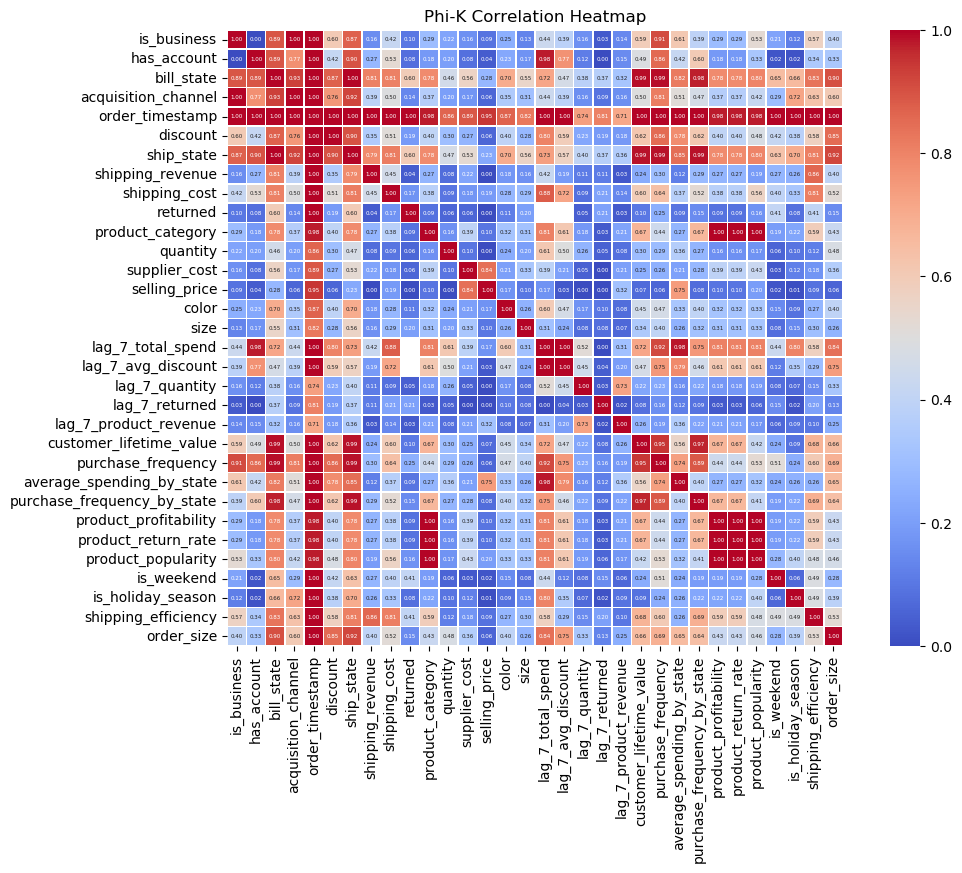

In [37]:
# Calculate the Phi-K correlation matrix from a sample of customers
phik_correlation_df = correlation_df.head(10000)
phik_correlation_df = phik_correlation_df.drop(columns = ['customer_uid', 'order_id', 'line_item_id'], axis = 1)
phik_matrix = phik_correlation_df.phik_matrix()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(phik_matrix, xticklabels = phik_matrix.columns, 
            yticklabels = phik_matrix.columns,
            annot=True, linewidth = 0.5, annot_kws = {'size': 4}, square = True,
            cmap='coolwarm', fmt=".2f")
plt.title('Phi-K Correlation Heatmap')
plt.show()

---

---

# 4. Product Recommendation using Item-based Collaborative Filtering

    Item-based Collaborative Filtering was developed by Amazon in 1998 and has played a great role in 
    their success.

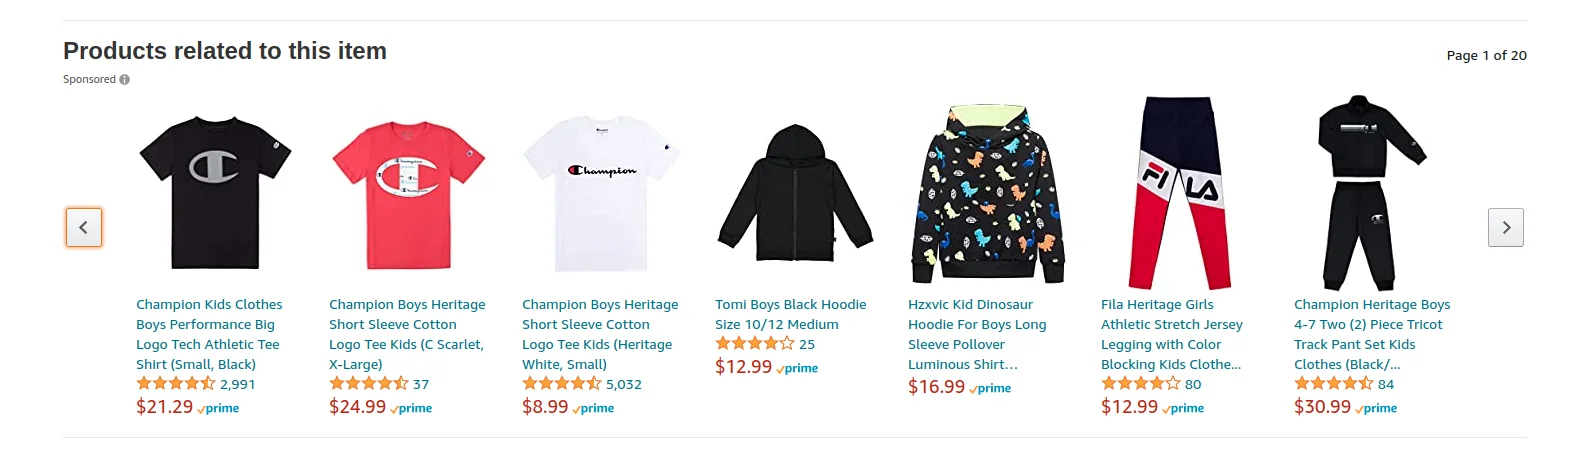

    In IBCF, similar items are recommended based on their relationship with other items. It basically 
    allows us to say, if many customers that bought item A also bought item B, then the two items are 
    considered similar.
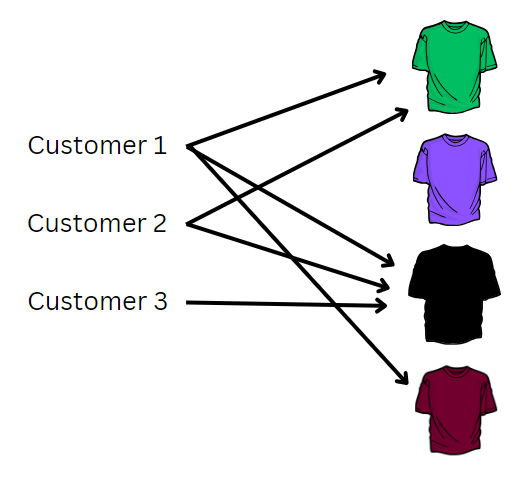

    So recommendations are made based on the "similarity" between different products to help customers find 
    shirts that are relevant to them based on known information about them in comparison to other customers 
    and shirts in the system. The underlying principle being: similar people like/purchase similar shirts.
    
### How are the recommendations generated and why are they relevant to the customer?

    The pivot table in the variable pivot_table is the customer-item matrix. The rows represent different 
    customers (customer_uid), and the columns represent different items (product_category). The values in 
    the matrix are the frequencies of purchases (frequency), indicating how many times a particular customer 
    has bought a particular item.

    The matrix is normalized by subtracting the mean frequency of each customer from their respective rows. 
    This makes sure that the system understands the relative importance of an item to a customer as opposed 
    to the absolute number of times an item has been purchased.

    The item-item similarity matrix is then calculated using cosine similarity, which measures the cosine of 
    the angle between two vectors.

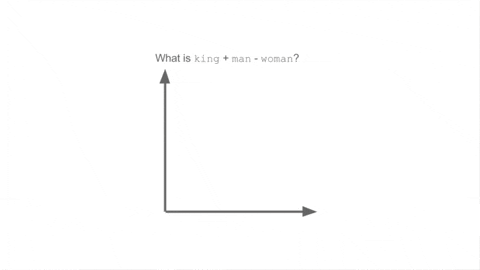

    The similarity matrix is then stored in df_item_similarity. Each entry sim(i, j) in this matrix 
    represents the similarity between item i and item j.


### To make recommendations for each customer: 
    
         ● The code identifies the items they have already bought (known_positives).
         
         ● Computes the scores for other items by taking the mean similarity of the known positives with 
           all other items. 
         
               - This estimates how much a customer would like an item based on their known positives, and 
                 is essentially a weighted sum of the similarities between the known positives and each of 
                 the other products.  
               
         ● Sorts the scores and picks the top 5 as recommendations.          
         
         ● And finally, the product scores are ranked to recommend the top N products that the customer 
           hasn't already bought.
           
           
### Why these recommendations?
    
         1. The recommendations are based on what the customer and similar customers have bought in the past. 
            If a customer has frequently purchased items in a particular category, it's likely they are 
            interested in that category.

         2. The recommender suggests items that are "similar" to what the customer has already bought. 
            "Similarity" here is defined by the behavior of all customers: if many customers who bought item 
            A also bought item B, then items A and B are considered similar according to their cosine 
            similarity.

         3. By ranking products based on the calculated scores, the system can offer a variety of products 
            that are not only popular but also relevant to the individual customer's preferences.
            
            
### So what?              

         I chose this method over something like a frequency-based recommender or market-basket analysis for 
         a few reasons: 
             
             ● It will give customers personalized recommendations and help them discover products they 
               might not be aware of, because customers like to feel valued and understood. A method like 
               this is likely to improve customer satisfaction, loyalty, engagement and could potentially 
               decrease churn. If products are also relevant to their interests, we can increase the 
               likelihood that they will make a purchase.
             
                 - If we know that customers who buy a specific type of T-shirt often buy a certain 
                   accessory, we might decide to offer them as a bundle at a discounted price.
                   
                 - If someone just bought a brand-logo T-shirt, they might also be interested in other 
                   merchandise from the same brand.
                   
                 - Style Cohesion: If a customer often buys vintage-style T-shirts, then similar retro 
                   designs can be recommended to them.
                   
             ● Given the correlation between product_category, purchase_frequency, 
               purchase_frequency_by_state, order_timestamp and average_discount_used, we could consider 
               regional preferences when making recommendations, which will increase the personalization 
               of the system. This could help provide more dynamic, time-sensitive recommendations for 
               events like flash sales or on seasonal products.
                   
                   
          Like any method, there are trade-offs. 
         
             ● This approach doesn't work well for new customers or new products with little to no 
               interaction history. 
               
                   - This could be mitigated by using a frequency-based strategy at first for new customers 
                     and then use that data to build them into a collaborative filtering strategy over time.

             ● The recommendations do not take into account contextual information like seasonality, current 
               trends, or external events, which could be very influential in purchasing decisions. 
               
                   - Data availability depending on the season or trend could help mitigate this. 
                     For example, by making summer items a priority in the summer etc.

             ● The system assumes that if you liked A and A is similar to B, then you will like B. This isn't 
               always true. 
             
                   - One easy way to introduce randomness would be to use multiple similarity metrics to 
                     diversify recommendations. For example, we could factor in different aspects such as 
                     brand, color, or material in addition to item similarity using a jaccard distance, in 
                     tandem with one of the many features from the correlation analysis to increase 
                     recommendation performance.                

###    Insights:
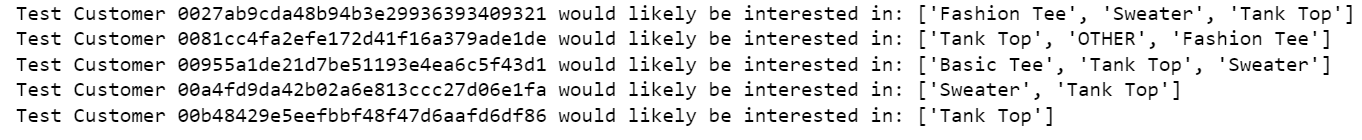    
     
     A test case for customer 0027ab9cda48b94b3e29936393409321, indicates that 'Fashion Tee,' 'Sweater,' 
     and 'Tank Top' are probably items that are frequently bought by customers who have also bought 
     'Basic Tee' or items in the 'OTHER' category.
               
     Since the customer has bought a 'Basic Tee,' it might be reasonable to assume they would be interested 
     in other types of shirts like a sweater or tank top.
     
     In this scenario, 'Fashion Tee' would be considered a safer recommendation as it's not extremely far 
     from 'Basic Tee' according to the t-SNE plot. Recommending this could be seen as a moderate step away 
     from what the customer has already bought, but is interested in, making it a reasonable recommendation.
               
     Without subject matter expertise, at a high level, these recommendations seem ok. If someone bought a 
     'Basic Tee', they might be interested in other kinds of tees or shirts in similar colors, styles, 
     brands depending on their discount, loyalty or the seasonality, which is what the model is capable 
     of recommending.          
               
     Ideally I would do an A/B test to see whether the customer actually clicks on or purchases these items. 
     This would provide the most direct measure of the quality of the recommendations. Customer feedback, 
     SME assesments, metrics like precision at k, recall at k, and F1-score would also be good measures of
     recommendation relevancy and the effectiveness of the recommendation algorithm.

In [38]:
# Get purchase data for all customers
purchase_data_query = """
                      SELECT o.customer_uid, li.product_category, COUNT(li.product_category) as frequency
                      FROM orders o
                      JOIN line_items li ON o.order_id = li.order_id
                      GROUP BY o.customer_uid, li.product_category;
                      """
df_purchase_data = pd.read_sql_query(purchase_data_query, conn)

In [39]:
df_purchase_data.head(20)

,customer_uid,product_category,frequency
0,00074f521fd7e7b8862d6de975bf7da0,Fashion Tee,1
1,00084927a1414e820a82782c9956c44a,Basic Tee,6
2,00084927a1414e820a82782c9956c44a,Fashion Tee,1
3,00084927a1414e820a82782c9956c44a,OTHER,9
4,0009df61ea36f0588581a45cba32343f,OTHER,3
5,001632349a7d0ca4aaef9d7ce70ed05b,Fashion Tee,6
6,001eb9af0c90990bde1a83d485946c25,Fashion Tee,4
7,002224cfcae0532fa94a1f5d071b43b3,Basic Tee,7
8,002224cfcae0532fa94a1f5d071b43b3,OTHER,2
9,0023271ac9655586c4f4744c81ab9920,Basic Tee,6


In [40]:
# A set of customers to train the recommender and a set of customers to test the recommender

# Get unique customer IDs
unique_customer_ids = df_purchase_data['customer_uid'].unique()

# Split customer IDs into training and testing sets
train_customer_ids, test_customer_ids = train_test_split(unique_customer_ids, test_size=0.2, random_state=42)

# Create dfs for training and testing based on the customer IDs
df_train = df_purchase_data[df_purchase_data['customer_uid'].isin(train_customer_ids)]
df_test = df_purchase_data[df_purchase_data['customer_uid'].isin(test_customer_ids)]

df_train.head(), df_test.head()

(                       customer_uid product_category  frequency
 0  00074f521fd7e7b8862d6de975bf7da0      Fashion Tee          1
 1  00084927a1414e820a82782c9956c44a        Basic Tee          6
 2  00084927a1414e820a82782c9956c44a      Fashion Tee          1
 3  00084927a1414e820a82782c9956c44a            OTHER          9
 4  0009df61ea36f0588581a45cba32343f            OTHER          3,
                         customer_uid product_category  frequency
 13  0027ab9cda48b94b3e29936393409321        Basic Tee          3
 14  0027ab9cda48b94b3e29936393409321            OTHER         11
 26  0081cc4fa2efe172d41f16a379ade1de        Basic Tee          4
 27  0081cc4fa2efe172d41f16a379ade1de          Sweater          4
 31  00955a1de21d7be51193e4ea6c5f43d1      Fashion Tee          4)

In [41]:
# Make recommendations for each customer

# Create a pivot table
pivot_table = df_train.pivot_table(index='customer_uid', columns='product_category', values='frequency', fill_value=0)

# Normalize the pivot table
pivot_table_normalized = pivot_table - np.mean(pivot_table, axis=1).values.reshape(-1, 1)

# Calculate the similarity matrix
item_similarity = cosine_similarity(pivot_table_normalized.T)

# Convert to df for better readability
df_item_similarity = pd.DataFrame(item_similarity, index=pivot_table.columns, columns=pivot_table.columns)

recommendations = {}
for customer in df_train['customer_uid'].unique():
    # Get products already bought by this customer
    known_positives = df_train[df_train['customer_uid'] == customer]['product_category'].tolist()
    
    # Predict scores for other products
    scores = df_item_similarity[known_positives].mean(axis=1)
    
    # Sort in descending order
    scores = scores.sort_values(ascending=False)
    
    # Remove known positives from the recommendation
    scores = scores.drop(known_positives, errors='ignore')
    
    # Get top 20 recommendations
    recommendations[customer] = scores.index[:20].tolist()

# Show recommendations for top 20 customers
for i, (customer, products) in enumerate(recommendations.items()):
    if i > 20:  # Choose number of customers to display
        break
    print(f"Customer {customer} would likely be interested in: {products}")

Customer 00074f521fd7e7b8862d6de975bf7da0 would likely be interested in: ['OTHER', 'Basic Tee', 'Tank Top', 'Sweater']
Customer 00084927a1414e820a82782c9956c44a would likely be interested in: ['Sweater', 'Tank Top']
Customer 0009df61ea36f0588581a45cba32343f would likely be interested in: ['Basic Tee', 'Fashion Tee', 'Sweater', 'Tank Top']
Customer 001632349a7d0ca4aaef9d7ce70ed05b would likely be interested in: ['OTHER', 'Basic Tee', 'Tank Top', 'Sweater']
Customer 001eb9af0c90990bde1a83d485946c25 would likely be interested in: ['OTHER', 'Basic Tee', 'Tank Top', 'Sweater']
Customer 002224cfcae0532fa94a1f5d071b43b3 would likely be interested in: ['Fashion Tee', 'Sweater', 'Tank Top']
Customer 0023271ac9655586c4f4744c81ab9920 would likely be interested in: ['OTHER', 'Sweater', 'Tank Top', 'Fashion Tee']
Customer 0025516109bb58324c695618944102f5 would likely be interested in: ['Tank Top', 'Basic Tee']
Customer 002f8816ca0a21db5b577fff5bd3b645 would likely be interested in: ['Basic Tee', 'T

In [42]:
# Debug behavior of the recommender to understand which products the customer has already purchased, 
# and show scores based on its similarity to the products that the customer has already purchased

# Iterates through each unique customer ID in the training set.
#for customer in df_train['customer_uid'].unique():
    # Calculate scores for products based on the products that the customer has already purchased
    # then average these scores across the 'known positives'.    
#    known_positives = df_train[df_train['customer_uid'] == customer]['product_category'].tolist()
#    scores = df_item_similarity[known_positives].mean(axis=1)
    # Higher scores mean that the product is more likely to be of interest to the customer   
#    scores = scores.sort_values(ascending=False)
    # Removed already purchased products from the recommendation list    
#    scores = scores.drop(known_positives, errors='ignore')    
#    print(f"Debug for {customer}:")
#    print(f"Known positives: {known_positives}")
#    print(f"Scores: {scores}")
    
#    recommendations[customer] = scores.index[:5].tolist()

In [43]:
# Train the Recommender Model using df_train

# Pivot table for training data
pivot_table_train = df_train.pivot_table(index='customer_uid', columns='product_category', values='frequency', fill_value=0)

# Normalize the pivot table
pivot_table_train_normalized = pivot_table_train - np.mean(pivot_table_train, axis=1).values.reshape(-1, 1)

# Calculate the similarity matrix
item_similarity = cosine_similarity(pivot_table_train_normalized.T)

# Convert to df for better readability
df_item_similarity = pd.DataFrame(item_similarity, index=pivot_table_train.columns, columns=pivot_table_train.columns)

# Test the Recommender on df_test
# Initialize recommendations dictionary for test customers
recommendations_test = {}

# Loop through each customer in df_test to get recommendations
for customer in df_test['customer_uid'].unique():
    # Get products already bought by this customer from the test data
    known_positives = df_test[df_test['customer_uid'] == customer]['product_category'].tolist()
    
    # Predict scores for other products using the similarity matrix built from the training data
    scores = df_item_similarity[known_positives].mean(axis=1)
    
    # Sort in descending order
    scores = scores.sort_values(ascending=False)
    
    # Remove known positives from the recommendation
    scores = scores.drop(known_positives, errors='ignore')
    
    # Get top 20 recommendations
    recommendations_test[customer] = scores.index[:5].tolist()

# Show recommendations for top 20 test customers
for i, (customer, products) in enumerate(recommendations_test.items()):
    if i >= 20:  
        break
    print(f"Test Customer {customer} would likely be interested in: {products}")

Test Customer 0027ab9cda48b94b3e29936393409321 would likely be interested in: ['Fashion Tee', 'Sweater', 'Tank Top']
Test Customer 0081cc4fa2efe172d41f16a379ade1de would likely be interested in: ['Tank Top', 'OTHER', 'Fashion Tee']
Test Customer 00955a1de21d7be51193e4ea6c5f43d1 would likely be interested in: ['Basic Tee', 'Tank Top', 'Sweater']
Test Customer 00a4fd9da42b02a6e813ccc27d06e1fa would likely be interested in: ['Sweater', 'Tank Top']
Test Customer 00b48429e5eefbbf48f47d6aafd6df86 would likely be interested in: ['Tank Top']
Test Customer 00d35b3cae57f070c371c1f7ac5f87b1 would likely be interested in: ['Tank Top', 'Basic Tee']
Test Customer 00d8833e50294b0c906efa5a0a95fb31 would likely be interested in: ['Basic Tee', 'Fashion Tee', 'Sweater', 'Tank Top']
Test Customer 0102738b4bb242a09e5f06c3cd40dd95 would likely be interested in: ['Basic Tee', 'Fashion Tee', 'Sweater', 'Tank Top']
Test Customer 01177eeb9909d1c62c006c2b35061dab would likely be interested in: ['Basic Tee', 'Fas

### Understanding Similarity & Dissimilarity Between Product Category Recommendations

    t-Distributed Stochastic Neighbor Embedding (t-SNE) is a dimensionality reduction technique. I'm using 
    it here to visualize how items are related to each other in the reduced dimensionality space of the 
    customer test set. Giving us some insight into the recommendations.

    It works by minimizing the divergence between two distributions: a distribution that measures pairwise 
    similarities of the input objects and a distribution that measures pairwise similarities of the 
    corresponding low-dimensional points in the embedding.

    Points that are close to each other in the plot represent items that are similar, according to the  model. 
    Clusters of points might represent groups of items that are commonly bought together, or share similar 
    characteristics. Outliers, or points that are far away from any cluster, might represent items that are 
    dissimilar to all other items.
    
    
### Observations:       
    
           Basic Tee is closest to the origin, indicating it might be a kind of "median" or "average" 
           product in terms of its similarity to other products.

           Tank Top is in the far negative space along Dimension 1 and Dimension 2, indicating it's quite 
           dissimilar to all the other categories in the context of the dataset.
       
       
### Insights:
       
           ● There are no tight clusters, which might mean that each category is fairly distinct from the 
           others in terms of customer purchasing behavior.
             
           ● The "Tank Top" category seems to be an outlier, which could indicate that it includes a wide 
             variety of products that don't fit well with the rest. Maybe this has something to do with 
             seasonality and customers by state.                          
             
           ● "Fashion Tee" and "Basic Tee" are relatively closer to each other, suggesting some level of 
             similarity or commonality in how they are bought.
             
           ● "Basic Tee" being near the origin could mean that it has some level of similarity with all other 
              categories, making it a versatile item for recommendations.
              
           ● "Fashion Tee" seems to be close to "Sweater" and "Basic Tee", suggesting that they are commonly 
              bought together or are similar in some important aspects (target demographic etc.)
              
              
### Call to action:
        
           ● Since the categories look fairly distinct, we can assume customer preferences are pretty 
             straightforward, so personalized recommendations are crucial. For example, if someone has 
             bought a lot of "Fashion Tees," recommending a "Tank Top" or something from "OTHER" may 
             not be effective.
             
           ● The distance between "Basic Tee" and "Fashion Tee" suggests there might be some opportunity for 
             cross-selling or bundling these items.     

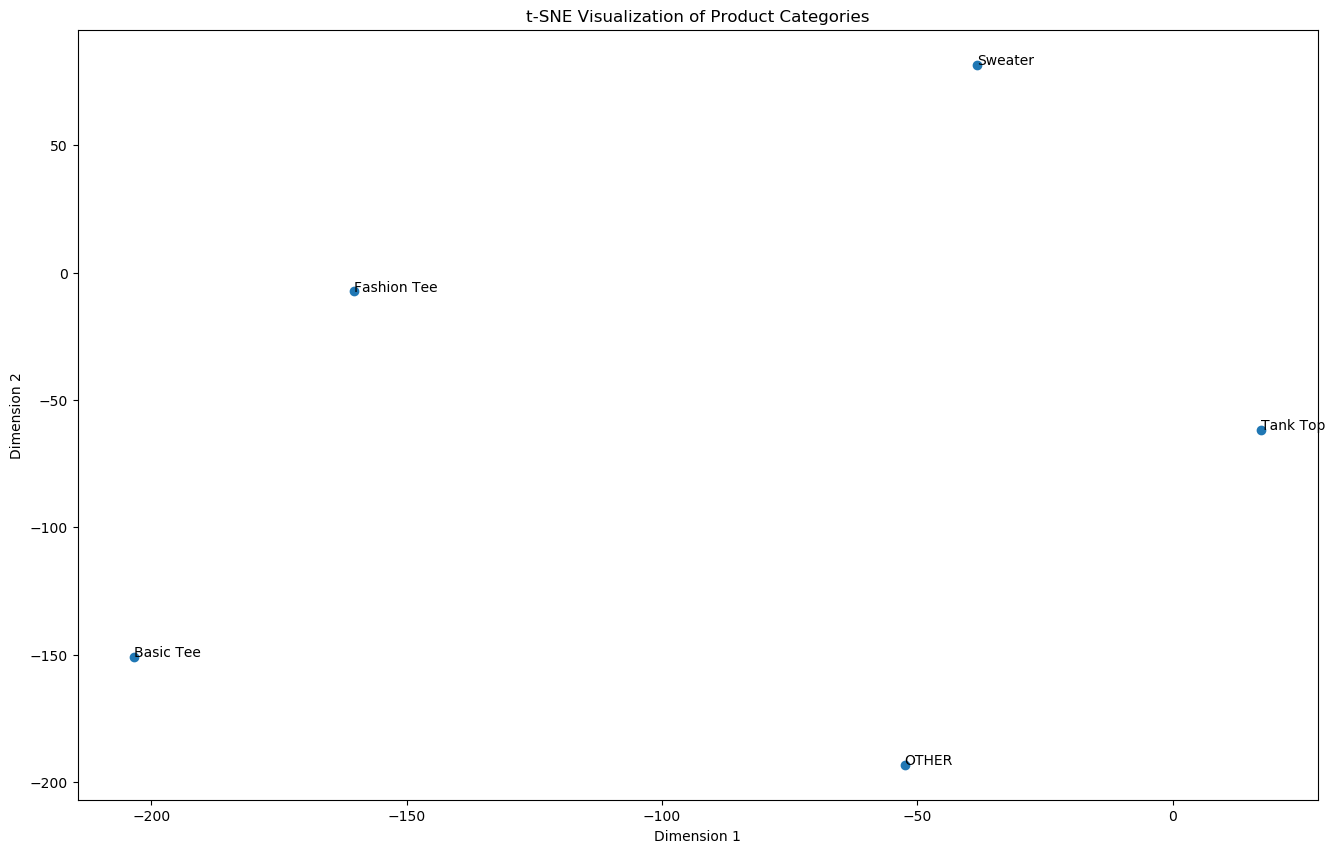

In [44]:
# Assuming df_item_similarity is item-item similarity df

# Convert df to numpy array
item_similarity_matrix = df_item_similarity.to_numpy()

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state = 36)
tsne_results = tsne.fit_transform(item_similarity_matrix)

# Create a df to store t-SNE results
tsne_df = pd.DataFrame(tsne_results, columns=['Dimension 1', 'Dimension 2'])
tsne_df['Product Category'] = df_item_similarity.columns

# Plot the t-SNE output
plt.figure(figsize=(16, 10))
plt.scatter(tsne_df['Dimension 1'], tsne_df['Dimension 2'])

for i, label in enumerate(tsne_df['Product Category']):
    plt.annotate(label, (tsne_df['Dimension 1'].iloc[i], tsne_df['Dimension 2'].iloc[i]))

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE Visualization of Product Categories')
plt.show()